In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>
<br>
<br>
<br>

# **Preparação dos Dados (DataPrep) - Final**

A etapa de preparação dos dados (dataprep) é crucial para o sucesso da modelagem de machine learning, pois os dados precisam estar limpos, organizados e em um formato adequado para serem utilizados pelos algoritmos de aprendizado de máquina. Isso inclui garantir a qualidade dos dados, ajustar o formato para atender aos requisitos dos algoritmos, garantir eficiência computacional, promover interpretabilidade e explicabilidade dos modelos e assegurar generalização e robustez.
<br>
<br>
Como agora se trata de um caso mais complexo, onde vamos treinar o modelo com a Regressão Logística e não se trata mais de um modelo baseline, vamos fazer o processo manualmente, passo por passo, sem o uso de pipeline, para ter um controle maior de cada etapa, caso seja necessário fazer algum ajuste específico, utilizar diferentes técnicas de pré-processamento e para permitir ter mais flexibilidade também.
<br>
<br>
Nesta etapa também iremos fazer a seleção das variáveis utilizando algumas das técnicas mais usadas, para que o nosso modelo seja treinado somente com as variáveis mais relevantes.
<br>
<br>
**Nota 1: Nesta etapa final iremos juntar todas as variáveis selecionadas nas etapas anteriores e fazer uma nova seleção de variáveis, através do Feature Importance e também fazer cortes com base na Correlação de Pearson e do IV.**
<br>
<br>
**Nota 2: Nesta estapa não há a necessidade de fazer a limpeza, pois já foi feita nas etapas anteriores, mas continuaremos com os tratamentos necessários das variáveis, após o Feature Selection.**

<br>

## **Pacotes e Bibliotecas**

In [ ]:
# Instalação dos Pacotes.
!pip install colorama > /dev/null
!pip install category_encoders > /dev/null

In [ ]:
# Importando as bibliotecas Pandas e Numpy.
import pandas as pd
import numpy as np

# Importando as constantes definidas na biblioteca colorama que permitem alterar as cores e estilos de texto impresso no terminal.
from colorama import Fore, Style

# Importando a pickle para serialização.
import pickle

# Importando os algoritmos de Machine Learning, da biblioteca Scikit-Learn, que iremos utilizar nesse projeto.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Importando a biblioteca Matplotlib e Seaborn para plotarmos gráficos que ajudarão no entendimento dos dados.
import matplotlib.pyplot as plt
import seaborn as sns

# Importanto as funções para codificação de variáveis.
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

<br>
<br>
<br>
<br>

## **Funções**

In [ ]:
# Função para checar quantidade de linhas e colunas dos conjuntos de treino e teste.
def info_dataframe(treino, teste):
    '''
    Esta função exibe informações sobre a quantidade de linhas e colunas dos conjuntos de treino e teste.

    Parâmetros:
    - treino: DataFrame do conjunto de treino.
    - teste: DataFrame do conjunto de teste.

    Retorna:
    Um print com as informações.
    '''

    # Criando uma borda destacada para o título do conjunto de treino.
    print(Fore.BLUE + '=' * 45)
    print('CONJUNTO DE TREINO'.center(45))
    print('')
    print('Quantidade de linhas:', treino.shape[0])
    print('Quantidade de colunas:', treino.shape[1])
    print('=' * 45 + Style.RESET_ALL)
    print('')

    # Criando uma borda destacada para o título do conjunto de teste.
    print(Fore.GREEN + '=' * 45)
    print('CONJUNTO DE TESTE'.center(45))
    print('')
    print('Quantidade de linhas:', teste.shape[0])
    print('Quantidade de colunas:', teste.shape[1])
    print('=' * 45 + Style.RESET_ALL)



# =================================================================================================================================================== #



# Função para verificar os metadados do conjunto de dados.
def generate_metadata(df, ids, targets, orderby = 'PC_NULOS'):
    '''
    Esta função retorna uma tabela com informações descritivas sobre um DataFrame.

    Parâmetros:
    - df: DataFrame que você quer descrever.
    - ids: Lista de colunas que são identificadores.
    - targets: Lista de colunas que são variáveis alvo.
    - orderby: Ordenar por uma coluna específica.

    Retorna:
    Um DataFrame com informações sobre o df original.
    '''

    summary = pd.DataFrame({
        'USO_FEATURE': ['ID' if col in ids else 'Target' if col in targets else 'Explicativa' for col in df.columns],
        'QT_NULOS': df.isnull().sum(),
        'PC_NULOS': round((df.isnull().sum() / len(df))* 100,2),
        'CARDINALIDADE': df.nunique(),
        'TIPO_FEATURE': df.dtypes
    })

    summary_sorted = summary.sort_values(by=orderby, ascending=False)
    summary_sorted = summary_sorted.reset_index()

    # Renomeando a coluna 'index' para 'FEATURES'.
    summary_sorted = summary_sorted.rename(columns={'index': 'FEATURE'})

    return summary_sorted



# =================================================================================================================================================== #



# Função para preenchimento dos valores nulos.
def custom_fillna(df):
    '''
    Esta função preenche os valores nulos do DataFrame com a média das colunas numéricas e com 'VERIFICAR' para as colunas categóricas.

    Parâmetros:
    - df: DataFrame a ser preenchido.

    Retorna:
    O DataFrame preenchido e um dicionário contendo as médias das colunas numéricas.
    '''

    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    means = {}

    for col in numerical_cols:
        means[col] = df[col].mean()
        df[col].fillna(means[col], inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('VERIFICAR')

    return df, means


# Função para preenchimento dos valores nulos em produção.
def custom_fillna_prod(df, means):
    '''
    Esta função preenche os valores nulos do DataFrame em produção.

    Parâmetros:
    - df: DataFrame a ser preenchido.
    - means: Dicionário contendo as médias das colunas numéricas.

    Retorna:
    O DataFrame preenchido.
    '''

    for col, mean_value in means.items():
      df[col].fillna(mean_value, inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('VERIFICAR')

    return df



# =================================================================================================================================================== #



# Função para o cálculo do WoE e IV.
def calculate_woe_iv(df, feature, target):
    '''
    Calcula WoE (Weight of Evidence) e IV (Information Value) para uma variável.

    Parâmetros:
    - df: DataFrame do conjunto de treino.
    - feature: Nome da variável.
    - target: Nome da variável Target.

    Retorna:
    Os valores de WoE e IV das variáveis.
    '''

    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': df[df[feature] == val].count()[feature],
            'Good': df[(df[feature] == val) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == val) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()

    # Adicionando uma pequena constante para evitar divisão por zero.
    dset['Distr_Good'] = dset['Distr_Good'].replace({0: 1e-10})
    dset['Distr_Bad'] = dset['Distr_Bad'].replace({0: 1e-10})

    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()

    return iv



# Função para a criação de uma tabela com o IV das variáveis.
def iv_table(df, target):
    '''
    Cria uma tabela com o IV das variáveis.

    Parâmetros:
    - df: DataFrame do conjunto de treino.
    - target: Nome da variável Target.

    Retorna:
    Uma tabela com IV para todas as variáveis em relação ao target.
    '''

    iv_list = []
    for col in df.columns:
        if col == target:
            continue
        iv = calculate_woe_iv(df, col, target)
        if iv < 0.02:
            predictiveness = 'Inútil para a predição'
        elif iv < 0.1:
            predictiveness = 'Preditor Fraco'
        elif iv < 0.3:
            predictiveness = 'Preditor Moderado'
        else:
            predictiveness = 'Preditor Forte'
        iv_list.append({
            'Variável': col,
            'IV': iv,
            'Preditividade': predictiveness
        })

    return pd.DataFrame(iv_list).sort_values(by='IV', ascending=False)



# =================================================================================================================================================== #



# Função para analisar a ordenação das variáveis.
def analyze_variable(dataframe, variable, target):
  '''
  Analisa a distribuição e a relação de uma variável com a variável de destino em um conjunto de dados.

  Parâmetros:
  - dataframe: DataFrame contendo os dados.
  - variable: Nome da variável a ser analisada.
  - target: Nome da variável target.

  Retorna:
  Um DataFrame contendo a taxa de evento e o volume para cada categoria da variável.
  Um gráfico que mostra o volume e a taxa de evento por categoria da variável.
  '''

  # Crie uma cópia explícita do DataFrame.
  df_copy = dataframe.copy()

  # Se a variável for numérica, arredonda para 4 casas decimais.
  if pd.api.types.is_numeric_dtype(df_copy[variable]):
      df_copy[variable] = df_copy[variable].round(4)
      df_copy[variable] = df_copy[variable].astype(str)

  # Calcula a taxa de evento e o volume para cada categoria da variável.
  result = df_copy.groupby(variable).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
  result.columns = [variable, 'Taxa_de_Evento', 'Volume']

  # Ordena o resultado pela Taxa de Evento em ordem decrescente.
  result = result.sort_values(by='Taxa_de_Evento', ascending=False)

  # Plota o gráfico.
  fig, ax1 = plt.subplots(figsize=(12, 6))

  # Eixo Y esquerdo: Volume.
  bars = ax1.bar(result[variable], result['Volume'], color='lightblue', label='Volume (Barras)')
  ax1.set_xlabel(variable)
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento.
  ax2 = ax1.twinx()
  lines = ax2.plot(result[variable], result['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink', label='Taxa de Evento (Linha)')
  ax2.set_ylabel('Taxa de Evento (%)', color='black')
  ax2.tick_params(axis='y', labelcolor='black')

  # Combina as legendas de ambos os eixos, filtrando rótulos que começam com '_'.
  plots = [item for item in bars + tuple(lines) if not item.get_label().startswith('_')]
  labels = [plot.get_label() for plot in plots]
  plt.legend(plots, labels, loc='upper left')

  plt.title(f'Volume e Taxa de Evento por {variable}')
  ax1.set_xticks(result[variable])
  ax1.set_xticklabels(result[variable], rotation=45, ha='right')  # Ajuste para centralizar os rótulos.
  plt.tight_layout()
  plt.show()

  return result



# =================================================================================================================================================== #



# Função para o agrupamento dos dados de um variável.
def group_and_plot_by_safra(dataframe, target, explicativa, domain_mapping):
  '''
  Agrupa os dados por uma variável explicativa, aplica um mapeamento de domínio e plota o resultado.

  Parâmetros:
  - dataframe: DataFrame contendo os dados.
  - target: Nome da variável target.
  - explicativa: Nome da variável explicativa a ser agrupada.
  - domain_mapping: Dicionário de mapeamento para os novos domínios da variável explicativa.

  Retorna:
  DataFrame contendo a transformação da variável explicativa e seu mapeamento original.
  '''

  df_copy = dataframe.copy()

  # Se a variável explicativa for numérica, arredonda para 4 casas decimais e converte para string.
  if pd.api.types.is_numeric_dtype(df_copy[explicativa]):
      df_copy[explicativa] = df_copy[explicativa].apply(lambda x: round(x, 4)).astype(str)

  # Cria uma coluna com os valores originais para mostrar a transformação posteriormente.
  df_copy['original_' + explicativa] = df_copy[explicativa]

  # Aplica o mapeamento para os novos domínios.
  df_copy[explicativa] = df_copy[explicativa].map(domain_mapping).fillna(df_copy[explicativa])

  # Cria um DataFrame de transformação.
  transformation_df = df_copy[[explicativa, 'original_' + explicativa]].drop_duplicates().sort_values(by='original_' + explicativa)
  transformation_df.rename(columns={explicativa:'TFB_'+explicativa,'original_' + explicativa:explicativa},inplace=True)

  return transformation_df


# Função para aplicar a transformação de agrupamento.
def apply_grouping(data, transformation_df, explicativa):
  '''
  Aplica a transformação de agrupamento a uma variável explicativa em um DataFrame.

  Parâmetros:
  - data: DataFrame contendo os dados a serem transformados.
  - transformation_df: DataFrame de transformação gerado pela função group_and_plot_by_safra.
  - explicativa: Nome da variável explicativa a ser transformada.

  Retorna:
  DataFrame com a variável explicativa transformada de acordo com os novos domínios.
  '''

  df_copy = data.copy()

  # Se a variável explicativa for numérica, arredonda para 4 casas decimais e converte para string.
  if pd.api.types.is_numeric_dtype(df_copy[explicativa]):
    df_copy[explicativa] = df_copy[explicativa].apply(lambda x: round(x, 4)).astype(str)

  # Une o DataFrame de transformação com os novos dados para aplicar a transformação.
  df_copy = df_copy.merge(transformation_df, left_on=explicativa, right_on=explicativa, how='left')

  # Aplica a transformação.
  colname_transformed = 'TFB_' + explicativa
  df_copy[explicativa] = df_copy[colname_transformed].fillna(df_copy[explicativa])

  # Remove a coluna original.
  df_copy.drop(columns=[explicativa], inplace=True)

  return df_copy


# Função para plotar os gráficos de treino e teste com a ordenação.
def analyze_variable_train_and_test(train, test, variable, target, figsize=None):
  '''
  Analisa a distribuição e a relação de uma variável com a variável target em conjuntos de dados de treino e teste.

  Parâmetros:
  - train: DataFrame contendo os dados de treino.
  - test: DataFrame contendo os dados de teste.
  - variable: Nome da variável a ser analisada.
  - target: Nome da variável target.
  - figsize: Tamanho da figura para os gráficos.

  Retorna:
  Um DataFrame contendo a taxa de evento e o volume para cada categoria da variável em conjunto de treino e teste.
  Um gráfico que mostra o volume e a taxa de evento por categoria da variável em conjunto de treino e teste.
  '''

  # Concatenate train e test datasets.
  concatenated_data = pd.concat([train, test], keys=['Train', 'Test'], names=['Dataset'])

  # Se a variável for numérica, arredonda para 4 casas decimais.
  if pd.api.types.is_numeric_dtype(concatenated_data[variable]):
      concatenated_data[variable] = concatenated_data[variable].round(4)
      concatenated_data[variable] = concatenated_data[variable].astype(str)

  # Calcula a taxa de evento e o volume para cada categoria da variável.
  result = concatenated_data.groupby([variable, 'Dataset']).agg({target: 'mean', variable: 'count'}).rename(columns={variable: 'Volume'}).reset_index()
  result.columns = [variable, 'Dataset', 'Taxa_de_Evento', 'Volume']

  # Ordena o resultado pela Taxa de Evento em ordem decrescente.
  result = result.sort_values(by=['Dataset', 'Taxa_de_Evento'], ascending=[True, False])

  # Plota o gráfico.
  if figsize == None:
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  else:
      fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

  # Aumenta o espaçamento horizontal entre gráficos.
  plt.subplots_adjust(wspace=0.5)

  # Eixo Y esquerdo: Volume - Train.
  bars_train = ax1.bar(result[result['Dataset'] == 'Train'][variable], result[result['Dataset'] == 'Train']['Volume'], color='lightblue', label='Volume (Barras)')
  ax1.set_xlabel(variable)
  ax1.set_ylabel('Volume', color='black')
  ax1.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento - Train.
  ax2_train = ax1.twinx()
  lines_train = ax2_train.plot(result[result['Dataset'] == 'Train'][variable], result[result['Dataset'] == 'Train']['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink')
  ax2_train.set_ylabel('Taxa de Evento (%)', color='black')
  ax2_train.tick_params(axis='y', labelcolor='black')

  # Adiciona título ao gráfico de Treino.
  ax1.set_title('Treino')
  plt.grid(False)

  # Eixo Y esquerdo: Volume - Test.
  bars_test = ax2.bar(result[result['Dataset'] == 'Test'][variable], result[result['Dataset'] == 'Test']['Volume'], color='lightblue', label='Volume (Barras)')
  ax2.set_xlabel(variable)
  ax2.set_ylabel('Volume', color='black')
  ax2.tick_params(axis='y', labelcolor='black')

  # Eixo Y direito: Taxa de Evento - Test.
  ax2_test = ax2.twinx()
  lines_test = ax2_test.plot(result[result['Dataset'] == 'Test'][variable], result[result['Dataset'] == 'Test']['Taxa_de_Evento'] * 100, marker='o', linestyle='-', color='hotpink')

  # Adiciona legendas apenas para as linhas - Train.
  ax2_train.legend(lines_train, ['Taxa de Evento'], loc='best')

  # Adiciona legendas apenas para as linhas - Test.
  ax2_test.legend(lines_test, ['Taxa de Evento'], loc='best')

  # Adiciona título ao gráfico de Teste.
  ax2.set_title('Teste')

  # Aumenta o espaçamento vertical entre linhas.
  plt.subplots_adjust(hspace=0.5)

  plt.suptitle(f'Volume e Taxa de Evento por {variable}', y=1.05, fontsize=13)
  plt.xticks(rotation=45, ha='right')  # Adicionado para melhor visualização dos labels no eixo X.
  plt.tight_layout()

  ax1.grid(False)
  ax2.grid(False)
  plt.grid(False)

  return result



# =================================================================================================================================================== #



# Função para categorização das variáveis.
def categorize_with_decision_tree(dataframe, n_categories, target, numeric_var):
  '''
  Categoriza uma variável numérica utilizando uma árvore de decisão.

  Parâmetros:
  - dataframe: DataFrame contendo os dados.
  - n_categories: Número de categorias desejadas.
  - target: Nome da variável target.
  - numeric_var: Nome da variável numérica a ser categorizada.

  Retorna:
  DataFrame contendo as categorias, taxa de evento, volume e limites dos bins.
  '''

  # Preparar os dados.
  X = dataframe[[numeric_var]]
  y = dataframe[target]

  # Treinar uma árvore de decisão com profundidade máxima igual ao número de categorias desejadas.
  tree = DecisionTreeClassifier(max_leaf_nodes=n_categories)
  tree.fit(X, y)

  # Predizer a categoria (folha) para cada entrada no DataFrame.
  leaf_ids = tree.apply(X)

  # Criar um DataFrame temporário com as categorias (folhas), a variável numérica e o target.
  temp_df = pd.DataFrame({numeric_var: dataframe[numeric_var], 'Leaf': leaf_ids, target: y})

  result = temp_df.groupby('Leaf').agg({target: 'mean', numeric_var: ['count', 'min', 'max']}).reset_index()
  result.columns = ['Leaf', 'Taxa_de_Evento', 'Volume', 'Lower_Bound', 'Upper_Bound']

  # Ajuste para garantir que os limites superior e inferior de bins adjacentes não se sobreponham.
  result = result.sort_values(by='Lower_Bound')
  for i in range(1, len(result)):
      result.iloc[i, 3] = max(result.iloc[i, 3], result.iloc[i-1, 4])

  # Definir o limite inferior do primeiro bin como -inf e o limite superior do último bin como inf.
  result.iloc[0, 3] = -np.inf
  result.iloc[-1, 4] = np.inf

  return result



# Função para criação dos bins.
def apply_tree_bins(data, transformation_df, numeric_var):
  '''
  Aplica os bins definidos pela árvore de decisão a uma variável numérica.

  Parâmetros:
  - data: DataFrame contendo os dados a serem transformados.
  - transformation_df: DataFrame contendo as informações de transformação geradas pela função categorize_with_decision_tree.
  - numeric_var: Nome da variável numérica a ser transformada.

  Retorna:
  DataFrame com a variável numérica transformada em bins.
  '''

  # Criando uma cópia do DataFrame.
  df_copy = data.copy()

  # Obtenha os limites superiores e ordene-os.
  upper_bounds = transformation_df['Upper_Bound'].sort_values().values

  # Use numpy.digitize para determinar a qual bin cada valor pertence.
  df_copy[f"TFT_{numeric_var}"] = np.digitize(df_copy[numeric_var].values, upper_bounds)
  df_copy.drop(axis=1,columns=[numeric_var],inplace=True)

  return df_copy

<br>
<br>
<br>
<br>

## **Diretórios**

In [ ]:
# Salvando o caminho do diretório principal.
dir = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech'

# Salvando o caminho do diretório dos arquivos pickle.
dir_pkl = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_regressao_logistica/artefatos'

# Salvando o caminho do diretório das ABTs.
dir_abt = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_regressao_logistica/abt'

<br>
<br>
<br>
<br>

## **Leitura e merge dos dados**

**Bases de Treino**

In [ ]:
# Lendo as bases de dados.
base1 = pd.read_csv(dir_abt + '/abt_train_fs_01.csv')
base2 = pd.read_csv(dir_abt + '/abt_train_fs_02.csv')
base3 = pd.read_csv(dir_abt + '/abt_train_fs_03.csv')
base4 = pd.read_csv(dir_abt + '/abt_train_fs_04.csv')
base5 = pd.read_csv(dir_abt + '/abt_train_fs_05.csv')
base6 = pd.read_csv(dir_abt + '/abt_train_fs_06.csv')

# Listando as colunas únicas de cada base de dados.
cols_base1 = set(base1.columns)
cols_base2 = set(base2.columns)
cols_base3 = set(base3.columns)
cols_base4 = set(base4.columns)
cols_base5 = set(base5.columns)
cols_base6 = set(base6.columns)

# Mesclar as bases.
abt_train_00 = base1.copy()  # Começa com a primeira base.

# Iterando sobre as bases restantes.
for base, cols in zip([base2, base3, base4, base5, base6], [cols_base2, cols_base3, cols_base4, cols_base5, cols_base6]):
    # Remove as colunas que já existem na base atual.
    cols_to_add = [col for col in base.columns if col not in abt_train_00.columns]
    # Mescla a base atual com a base acumulada.
    abt_train_00 = abt_train_00.merge(base[cols_to_add + ['SK_ID_CURR']], on='SK_ID_CURR', how='outer')

# Mostrando tamanho da base após o merge.
print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame: ', abt_train_00.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame:  (172205, 15)



In [ ]:
# Definindo a opção para não truncar colunas.
pd.set_option('display.max_columns', None)

abt_train_00.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,TARGET,SK_ID_CURR,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,0,281575,625500.0,34060.5,625500.0,4994.550000,4994.550000,4994.55000,4994.550000
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,0,253241,278811.0,14364.0,189000.0,7911.140000,7911.140000,1076.58000,1076.580000
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,0,257591,193500.0,20529.0,193500.0,20029.939481,14352.211437,12372.27269,11432.662661
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,0,440634,135000.0,7668.0,135000.0,20029.939481,6.980000,6.98000,6.980000
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,0,101232,1288350.0,37800.0,1125000.0,20029.939481,8649.270000,8649.27000,8649.270000
5,-19362,0.676316,0.652185,0.771362,0.782964,0.029338,0,378713,1333395.0,39118.5,1044000.0,33018.840000,4715.010000,4715.01000,4715.010000
6,-18998,0.735231,0.638518,0.000527,0.926606,0.067590,0,253842,257391.0,17397.0,238500.0,20029.939481,14352.211437,12372.27269,11432.662661
7,-22662,0.502984,0.238028,0.712155,0.834725,0.044772,0,223682,177903.0,7965.0,148500.0,20029.939481,5478.530000,5478.53000,5478.530000
8,-11520,0.204120,0.020129,0.380800,1.000000,0.047429,0,421310,157500.0,7470.0,157500.0,4919.130000,4919.130000,4919.13000,4919.130000
9,-24871,0.502984,0.678039,0.510966,0.909918,0.071647,0,290144,247275.0,17716.5,225000.0,13282.200000,13282.200000,13282.20000,13282.200000


<br>

**Bases de Teste**

In [ ]:
# Lendo as bases de dados.
base1 = pd.read_csv(dir_abt + '/abt_test_fs_01.csv')
base2 = pd.read_csv(dir_abt + '/abt_test_fs_02.csv')
base3 = pd.read_csv(dir_abt + '/abt_test_fs_03.csv')
base4 = pd.read_csv(dir_abt + '/abt_test_fs_04.csv')
base5 = pd.read_csv(dir_abt + '/abt_test_fs_05.csv')
base6 = pd.read_csv(dir_abt + '/abt_test_fs_06.csv')

# Listando as colunas únicas de cada base de dados.
cols_base1 = set(base1.columns)
cols_base2 = set(base2.columns)
cols_base3 = set(base3.columns)
cols_base4 = set(base4.columns)
cols_base5 = set(base5.columns)
cols_base6 = set(base6.columns)

# Mesclar as bases.
abt_test_00 = base1.copy()  # Começa com a primeira base.

# Iterando sobre as bases restantes.
for base, cols in zip([base2, base3, base4, base5, base6], [cols_base2, cols_base3, cols_base4, cols_base5, cols_base6]):
    # Remove as colunas que já existem na base atual.
    cols_to_add = [col for col in base.columns if col not in abt_test_00.columns]
    # Mescla a base atual com a base acumulada.
    abt_test_00 = abt_test_00.merge(base[cols_to_add + ['SK_ID_CURR']], on='SK_ID_CURR', how='outer')

# Mostrando tamanho da base após o merge.
print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame: ', abt_test_00.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame:  (43052, 15)



In [ ]:
# Definindo a opção para não truncar colunas.
pd.set_option('display.max_columns', None)

abt_test_00.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,TARGET,SK_ID_CURR,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,0,243431,180000.0,9000.0,180000.0,13344.890000,13344.890000,13344.89000,13344.890000
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,0,127962,781920.0,42547.5,675000.0,20029.939481,14352.211437,12372.27269,11432.662661
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,1,244667,450000.0,21888.0,450000.0,20029.939481,11290.910000,9710.55000,8894.610000
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,0,220032,760225.5,32337.0,679500.0,20029.939481,4736.480000,4736.48000,4736.480000
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,0,123746,808650.0,26217.0,675000.0,20029.939481,14352.211437,12372.27269,11432.662661
5,-10319,0.675956,0.697849,0.607557,0.825630,0.047046,0,169967,305221.5,14359.5,252000.0,48442.230000,9784.800000,9784.80000,9784.800000
6,-20542,0.502984,0.470580,0.569149,0.863260,0.030443,0,120237,1042560.0,31738.5,900000.0,20029.939481,14352.211437,12372.27269,11432.662661
7,-14498,0.502984,0.655461,0.639708,0.893815,0.039656,0,445579,755190.0,29947.5,675000.0,5.180000,5.180000,5.18000,5.180000
8,-12166,0.640963,0.731620,0.856413,0.926612,0.053453,0,125013,728460.0,38938.5,675000.0,20029.939481,14352.211437,12372.27269,11432.662661
9,-12516,0.502984,0.280041,0.355639,0.825627,0.067066,1,246301,545040.0,36553.5,450000.0,20029.939481,14352.211437,330.48000,330.480000


<br>
<br>
<br>
<br>

## **Seleção de Variáveis (Feature Selection)**

A etapa de seleção de variáveis contribui para a construção de modelos mais precisos, eficientes e interpretáveis, pois permite identificar e utilizar apenas as variáveis mais relevantes para prever o resultado desejado. Isso não apenas melhora a eficiência computacional e reduz o tempo de treinamento, mas também ajuda a evitar overfitting, aumenta a interpretabilidade dos modelos e facilita a identificação de padrões significativos nos dados.
<br>
<br>
Existem diversos métodos para fazer essa seleção de variáveis. No caso dos problemas de classificação, podemos citar: Feature Importance, Boruta, RFE, IV - Information Value, entre outros.
<br>
<br>
Neste projeto, iremos utilizar como método principal o **Feature Importance**, que é um método derivado de modelos específicos, e a formulação matemática para calcular essa importância pode variar dependendo do modelo. Ele nos dá uma ideia de quais variáveis têm maior impacto no modelo. Podemos usar alguns algoritmos para esse método, mas a escolha pode impactar tanto no desempenho, quanto no tempo de processamento dessa seleção. Para exemplificar, iremos utilizar nesse momento o **GradientBoostingClassifier**, por ter uma boa performance. Posteriormente podemos fazer testes com o **RandomForestClassifier**, **DecisionTreeClassifier** e o **XGBoost**.
<br>
<br>
Vamos utillizar também a Correlação de Pearson e o IV - Information Value  como critério de seleção de variáveis.
<br>
<br>
Outros métodos usados para seleção de variáveis são: Eliminação de variáveis por % de valores nulos e por variância (por exemplo, variável constante). Nas etapas anteriores já fizemos o tratamento das variáveis com alto percentual de valores nulos e das variáveis constantes.

<br>

### **Treinamento do modelo de seleção de variáveis**

In [ ]:
# Separando o Target da ABT de variáveis numéricas.
X = abt_train_00.drop(axis=1, columns=['TARGET', 'SK_ID_CURR'])
y = abt_train_00.TARGET

In [ ]:
# Treinando modelo com algoritmo Gradient Boosting.
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X, y)

GradientBoostingClassifier(random_state=42)

<br>

### **Escolha das variáveis através da técnica de Feature Importance**

In [ ]:
# Obtendo a importância das variáveis.
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenando as variáveis por importância.
features = features.sort_values(by='Importance', ascending=False)

# Estabelecendo um limite de corte, por exemplo, x% da importância máxima.
cutoff_maximp = 0.05
cutoff = cutoff_maximp * feature_importances.max()

# Selecionando variáveis acima do corte.
selected_features = X.columns[feature_importances > cutoff].tolist()

# Filtrando o DataFrame para apenas as features acima do corte.
selected_features_df = features[features['Importance'] > cutoff]

# Contar o número de variáveis selecionadas.
count_selected_features = len(selected_features_df)

# Imprimindo a quantidade de variáveis selecionadas.
print('')
print(Fore.RED + 'Número de variáveis selecionadas:', count_selected_features)
print(Style.RESET_ALL)
print('')
print('')

selected_features_df


Número de variáveis selecionadas: 10





,Feature,Importance
3,EXT_SOURCE_3,0.329035
2,EXT_SOURCE_2,0.293751
1,EXT_SOURCE_1,0.090453
5,NEW_PAYMENT_RATE_APP_TRAIN,0.077276
4,GOODS_CREDIT_RATIO_APP_TRAIN,0.051171
0,DAYS_BIRTH,0.034951
12,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,0.028865
7,AMT_ANNUITY,0.023416
11,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREV...,0.020335
9,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,0.019613


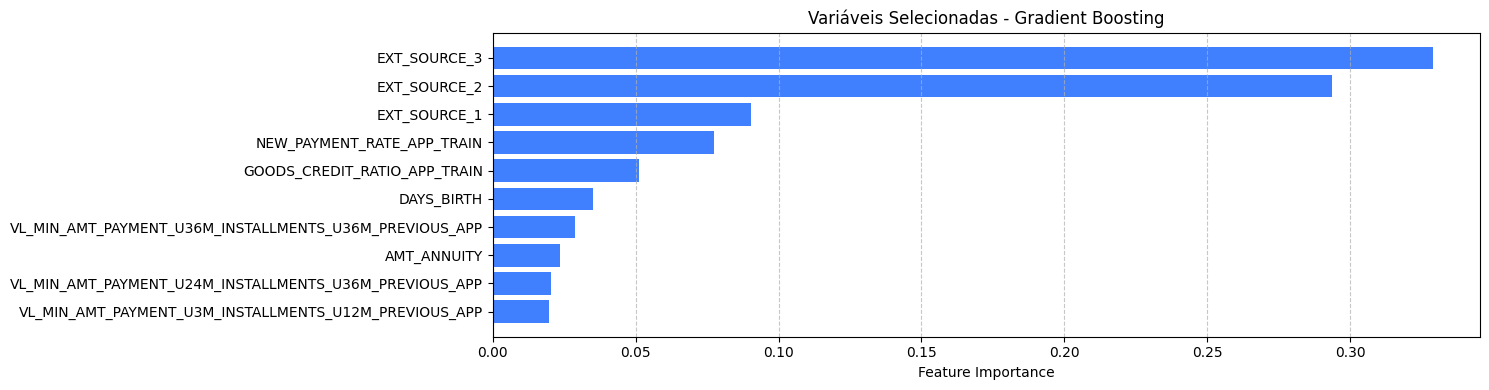

In [ ]:
# Ordenando as variáveis por importância.
features = features.sort_values(by='Importance', ascending=True)

# Filtrando o DataFrame para apenas as features acima do corte.
selected_features_df = features[features['Importance'] > cutoff]

# Visualizando a importância das variáveis em barras horizontais.
plt.figure(figsize=(15, len(selected_features_df)*0.4))
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel('Feature Importance')
plt.title('Variáveis Selecionadas - Gradient Boosting')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Salvando a lista de variáveis selecionadas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_list_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

In [ ]:
# Carregando a lista do arquivo .pkl.
with open(dir_pkl + '/prd_list_features.pkl', 'rb') as f:
    loaded_lista = pickle.load(f)

print(Fore.BLUE + '=' * 150)
print('')
print('Lista das variáveis selecionadas: ', loaded_lista)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista das variáveis selecionadas:  ['DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'GOODS_CREDIT_RATIO_APP_TRAIN', 'NEW_PAYMENT_RATE_APP_TRAIN', 'AMT_ANNUITY', 'VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP', 'VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP', 'VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP']



In [ ]:
# Incluindo a variável target e id na lista de variáveis explicativas selecionadas.
abt_train_01 = abt_train_00[loaded_lista + ['TARGET', 'SK_ID_CURR']]
abt_test_01 = abt_test_00[loaded_lista + ['TARGET', 'SK_ID_CURR']]

abt_train_01.shape, abt_test_01.shape

((172205, 12), (43052, 12))

In [ ]:
abt_train_01.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,SK_ID_CURR
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,34060.5,4994.550000,4994.55000,4994.550000,0,281575
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,14364.0,7911.140000,1076.58000,1076.580000,0,253241
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,20529.0,20029.939481,12372.27269,11432.662661,0,257591
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,7668.0,20029.939481,6.98000,6.980000,0,440634
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,37800.0,20029.939481,8649.27000,8649.270000,0,101232


In [ ]:
abt_test_01.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,SK_ID_CURR
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,9000.0,13344.890000,13344.89000,13344.890000,0,243431
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,42547.5,20029.939481,12372.27269,11432.662661,0,127962
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,21888.0,20029.939481,9710.55000,8894.610000,1,244667
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,32337.0,20029.939481,4736.48000,4736.480000,0,220032
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,26217.0,20029.939481,12372.27269,11432.662661,0,123746


<br>

### **Trazendo de volta as variáveis categóricas**

In [ ]:
# Lendo as bases de dados.
abt_train_cat = pd.read_csv(dir_abt + '/abt_train_cat.csv')
abt_test_cat = pd.read_csv(dir_abt + '/abt_test_cat.csv')

In [ ]:
# Concatenando as variáveis do abt de treino com as variáveis da abt de variáveis categóricas.
abt_train_02 = pd.merge(abt_train_01, abt_train_cat, on='SK_ID_CURR')

abt_train_02.shape

(172205, 28)

In [ ]:
# Dropando coluna de Id.
abt_train_03 = abt_train_02.drop('SK_ID_CURR', axis=1)

In [ ]:
abt_train_03.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,34060.5,4994.550000,4994.55000,4994.550000,0,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Trade: type 7,reg oper account,block of flats,"Stone, brick",No
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,14364.0,7911.140000,1076.58000,1076.580000,0,Cash loans,M,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,SUNDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,20529.0,20029.939481,12372.27269,11432.662661,0,Cash loans,F,N,N,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,Managers,WEDNESDAY,Business Entity Type 3,VERIFICAR,block of flats,Panel,No
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,7668.0,20029.939481,6.98000,6.980000,0,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,MONDAY,XNA,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,37800.0,20029.939481,8649.27000,8649.270000,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Waiters/barmen staff,FRIDAY,Business Entity Type 3,VERIFICAR,block of flats,"Stone, brick",No


In [ ]:
# Concatenando as variáveis do abt de teste com as variáveis da abt de variáveis categóricas.
abt_test_02 = pd.merge(abt_test_01, abt_test_cat, on='SK_ID_CURR')

abt_test_02.shape

(43052, 28)

In [ ]:
# Dropando coluna de Id.
abt_test_03 = abt_test_02.drop('SK_ID_CURR', axis=1)

In [ ]:
abt_test_03.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,9000.0,13344.890000,13344.89000,13344.890000,0,Revolving loans,M,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,Laborers,WEDNESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,42547.5,20029.939481,12372.27269,11432.662661,0,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Business Entity Type 3,reg oper account,block of flats,Wooden,No
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,21888.0,20029.939481,9710.55000,8894.610000,1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,THURSDAY,Construction,VERIFICAR,terraced house,Wooden,No
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,32337.0,20029.939481,4736.48000,4736.480000,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,TUESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,26217.0,20029.939481,12372.27269,11432.662661,0,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,TUESDAY,School,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR


<br>

### **Mapa de correlação de Pearson para as variáveis selecionadas**

Ao plotar um mapa de correlação de Pearson, podemos visualizar de forma rápida e intuitiva as relações lineares entre as variáveis selecionadas. Uma alta correlação positiva entre duas variáveis sugere que elas variam juntas na mesma direção, enquanto uma alta correlação negativa indica que elas variam inversamente. Por outro lado, uma correlação próxima a zero indica que as variáveis têm pouca ou nenhuma relação linear entre si.
<br>
<br>
Essa análise é importante para identificar se existe alguma alta correlação entre as variáveis, o que pode indicar redundância ou multicolinearidade no conjunto de dados.
  - **Redundância:** Variáveis altamente correlacionadas podem fornecer informações redundantes para o modelo, o que pode levar a uma sobrecarga de informações e aumentar o tempo de treinamento sem melhorar significativamente o desempenho do modelo.
  - **Multicolinearidade:** A multicolinearidade ocorre quando duas ou mais variáveis estão altamente correlacionadas entre si, o que pode levar a problemas na interpretação dos coeficientes do modelo e na instabilidade das previsões.

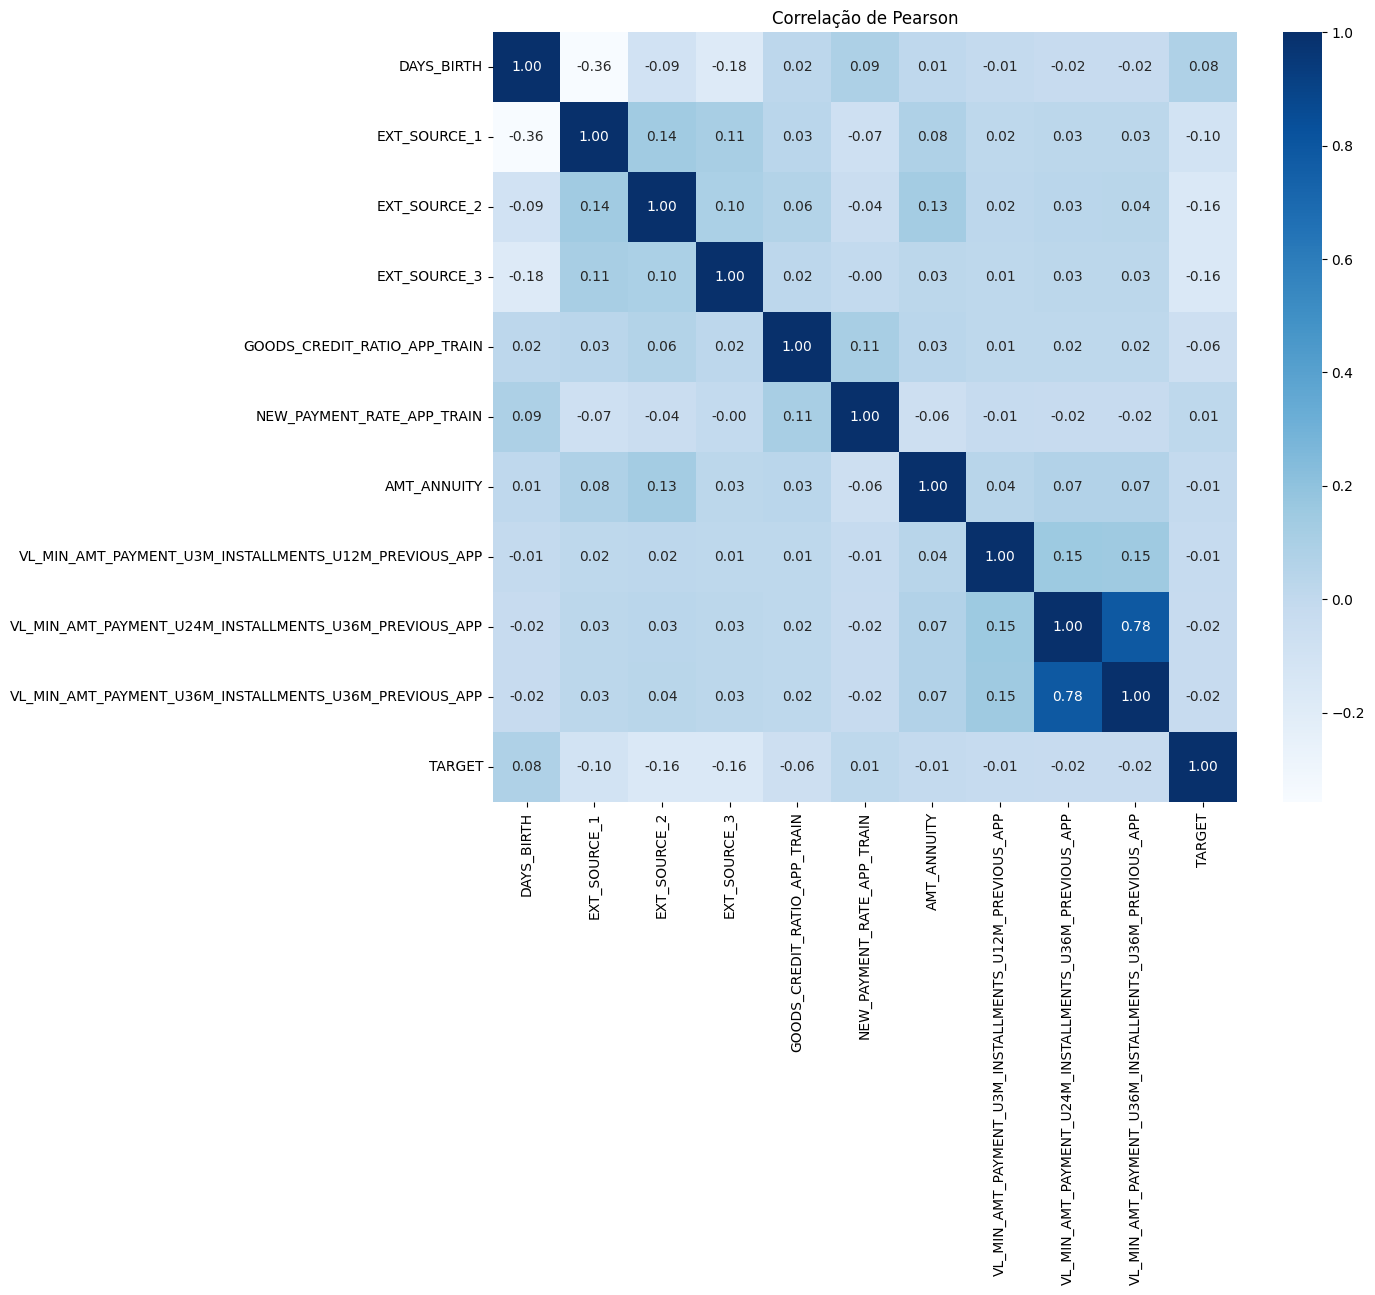

In [ ]:
# Calculando a correlação de Pearson.
abt_train_03_numeric = abt_train_03.select_dtypes(include=['number'])
corr_matrix = abt_train_03_numeric.corr()

# Plotando o heatmap.
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, fmt='.2f')
plt.title('Correlação de Pearson')
plt.show()

Podemos notar que existem duas variáveis com alta correlação entre si.

<br>

### **Verificação da força das variáveis explicativas com IV**

O Information Value (IV) é uma medida estatística que avalia a força da relação entre uma variável independente e a variável dependente em um modelo de classificação. O IV é importante porque permite identificar quais variáveis têm maior poder preditivo e contribuição para o modelo, ajudando na priorização e seleção das melhores características para melhorar a precisão do modelo de machine learning. Quanto maior o IV de uma variável, maior é sua capacidade de discriminar entre as classes da variável dependente, o que indica sua importância na previsão do resultado desejado.
<br>
<br>
**Vale ressaltar:** Enquanto a **Feature Importance** é uma medida do quanto cada variável contribui para a capacidade de previsão do modelo, com base na relação de uma variável explicativa com as outras variáveis explicativas o **IV** é uma medida da força da relação entre uma variável explicativa e a variável target em um modelo. Ambas tem sua importância e usabilidade.

In [ ]:
# Fazendo uma amostra dos dados.
abt_corr_aux_sample = abt_train_03.sample(n=15000)

In [ ]:
# Chamando a função.
iv_df = iv_table(abt_corr_aux_sample, 'TARGET')
iv_df

,Variável,IV,Preditividade
2,EXT_SOURCE_2,27.308280,Preditor Forte
0,DAYS_BIRTH,21.093765,Preditor Forte
9,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,20.864972,Preditor Forte
8,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREV...,20.744516,Preditor Forte
5,NEW_PAYMENT_RATE_APP_TRAIN,15.627698,Preditor Forte
6,AMT_ANNUITY,13.085619,Preditor Forte
1,EXT_SOURCE_1,12.307559,Preditor Forte
7,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,8.507071,Preditor Forte
3,EXT_SOURCE_3,3.345427,Preditor Forte
4,GOODS_CREDIT_RATIO_APP_TRAIN,2.501031,Preditor Forte


<br>

### **Remoção das variáveis de acordo com a análise da Matriz de Correlação e do Information Value (IV)**

**Remoção das variáveis com alta correlação**

O código abaixo pega os pares de variáveis com correlação maior ou igual ao limiar determinado. Em cada par, ele vai verificar a variável que tem o menor IV e vai coloca-la em uma lista para ser removida.

In [ ]:
# Definindo limiar de correlação.
limiar_corr = 0.70

# Criando uma lista com pares de variáveis com correlação absoluta >= o limiar.
corr_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j])
              for i in range(len(corr_matrix.columns))
              for j in range(i + 1, len(corr_matrix.columns))
              if abs(corr_matrix.iloc[i, j]) >= limiar_corr]

# Encontrando as variáveis com menor IV em cada par e adicionando à lista vars_to_drop_corr.
vars_to_drop_corr = []
for var1, var2 in corr_pairs:
    iv_values = iv_df.set_index('Variável').loc[[var1, var2], 'IV']
    var_to_drop = iv_values.idxmin()
    vars_to_drop_corr.append(var_to_drop)

# Removendo duplicatas da lista vars_to_drop_corr.
vars_to_drop_corr = list(set(vars_to_drop_corr))

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de variáveis para remover devido à alta correlação e baixo IV:', vars_to_drop_corr)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista de variáveis para remover devido à alta correlação e baixo IV: ['VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP']



In [ ]:
# Removendo as variáveis com alta correlação.
abt_train_04 = abt_train_03.drop(abt_train_03[vars_to_drop_corr], axis=1)

abt_train_04.shape

(172205, 26)

In [ ]:
abt_train_04.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,34060.5,4994.550000,4994.550000,0,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Trade: type 7,reg oper account,block of flats,"Stone, brick",No
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,14364.0,7911.140000,1076.580000,0,Cash loans,M,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,SUNDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,20529.0,20029.939481,11432.662661,0,Cash loans,F,N,N,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,Managers,WEDNESDAY,Business Entity Type 3,VERIFICAR,block of flats,Panel,No
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,7668.0,20029.939481,6.980000,0,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,MONDAY,XNA,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,37800.0,20029.939481,8649.270000,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Waiters/barmen staff,FRIDAY,Business Entity Type 3,VERIFICAR,block of flats,"Stone, brick",No


In [ ]:
# Salvando a lista de variáveis removidas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_vars_to_drop_corr.pkl', 'wb') as f:
    pickle.dump(vars_to_drop_corr, f)

In [ ]:
# Carregando o pkl com a lista de variáveis a serem removidas.
with open(dir_pkl + '/prd_vars_to_drop_corr.pkl', 'rb') as f:
    loaded_vars_to_drop_corr = pickle.load(f)

# Aplicando a remoção das variáveis na tabela de teste.
abt_test_04 = abt_test_03.drop(axis=1, columns=loaded_vars_to_drop_corr)

abt_test_04.shape

(43052, 26)

In [ ]:
abt_test_04.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,9000.0,13344.890000,13344.890000,0,Revolving loans,M,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,Laborers,WEDNESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,42547.5,20029.939481,11432.662661,0,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Business Entity Type 3,reg oper account,block of flats,Wooden,No
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,21888.0,20029.939481,8894.610000,1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,THURSDAY,Construction,VERIFICAR,terraced house,Wooden,No
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,32337.0,20029.939481,4736.480000,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,TUESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,26217.0,20029.939481,11432.662661,0,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,TUESDAY,School,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR


<br>

**Remoção das variáveis de acordo com o valor do IV**

In [ ]:
# Criando uma lista vazia para armazenar os nomes das colunas com preditividade "Inútil para a predição".
vars_to_drop_iv = []

# Criando uma lista com os critérios que queremos filtrar.
status_predit = ['Inútil para a predição']  # Podemos também filtrar por 'Preditor Fraco'.

# Itera sobre as linhas do DataFrame iv_df.
for index, row in iv_df.iterrows():
    # Verifica se a preditividade está dentro dos critérios que queremos filtrar.
    if row['Preditividade'] in status_predit:
        # Adicionar o nome da coluna à lista vars_to_drop_iv.
        vars_to_drop_iv.append(row['Variável'])

# Iterando sobre as listas criadas.
for item in vars_to_drop_corr:
    if item in vars_to_drop_iv:
        vars_to_drop_iv.remove(item)

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de variáveis para remover devido ao baixo valor de IV:', vars_to_drop_iv)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista de variáveis para remover devido ao baixo valor de IV: ['HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FONDKAPREMONT_MODE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_OWN_REALTY']



In [ ]:
# Removendo as variáveis com alta correlação.
abt_train_05 = abt_train_04.drop(abt_train_04[vars_to_drop_iv], axis=1)

abt_train_05.shape

(172205, 20)

In [ ]:
abt_train_05.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,34060.5,4994.550000,4994.550000,0,Cash loans,F,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,Trade: type 7,"Stone, brick"
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,14364.0,7911.140000,1076.580000,0,Cash loans,M,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,Business Entity Type 3,Panel
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,20529.0,20029.939481,11432.662661,0,Cash loans,F,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,Managers,Business Entity Type 3,Panel
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,7668.0,20029.939481,6.980000,0,Cash loans,F,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,XNA,VERIFICAR
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,37800.0,20029.939481,8649.270000,0,Cash loans,F,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Waiters/barmen staff,Business Entity Type 3,"Stone, brick"


In [ ]:
# Salvando a lista de variáveis removidas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_vars_to_drop_iv.pkl', 'wb') as f:
    pickle.dump(vars_to_drop_iv, f)

In [ ]:
# Carregando o pkl com a lista de variáveis a serem removidas.
with open(dir_pkl + '/prd_vars_to_drop_iv.pkl', 'rb') as f:
    loaded_vars_to_drop_iv = pickle.load(f)

# Aplicando a remoção das variáveis na tabela de teste.
abt_test_05 = abt_test_04.drop(axis=1, columns=loaded_vars_to_drop_iv)

abt_test_05.shape

(43052, 20)

In [ ]:
abt_test_05.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,9000.0,13344.890000,13344.890000,0,Revolving loans,M,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,Laborers,Business Entity Type 3,VERIFICAR
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,42547.5,20029.939481,11432.662661,0,Cash loans,F,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,Business Entity Type 3,Wooden
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,21888.0,20029.939481,8894.610000,1,Cash loans,M,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,Construction,Wooden
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,32337.0,20029.939481,4736.480000,0,Cash loans,F,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,Business Entity Type 3,VERIFICAR
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,26217.0,20029.939481,11432.662661,0,Cash loans,F,Family,State servant,Higher education,Married,House / apartment,Core staff,School,VERIFICAR


<br>

### **Dropando colunas com dados sensíveis e trazendo o ID novamente para a tabela**

In [ ]:
# Lista de colunas que iremos dropar.
col_to_drop = ['CODE_GENDER']

# Dropando as colunas do DataFrame.
abt_train_06 = abt_train_05.drop(columns=col_to_drop)
abt_test_06 = abt_test_05.drop(columns=col_to_drop)

# Trazaneo o ID novamente.
abt_train_07 = pd.concat([abt_train_06, abt_train_02['SK_ID_CURR']], axis=1)
abt_test_07 = pd.concat([abt_test_06, abt_test_02['SK_ID_CURR']], axis=1)

info_dataframe(abt_train_07, abt_test_07)

              CONJUNTO DE TREINO             

Quantidade de linhas: 172205
Quantidade de colunas: 20

              CONJUNTO DE TESTE              

Quantidade de linhas: 43052
Quantidade de colunas: 20


<br>
<br>

### **Salvando as variáveis selecionadas**

In [ ]:
# Salvando as variáveis selecionadas.
abt_train_07.to_csv(dir_abt + '/abt_train_fs_final.csv', index=False)
abt_test_07.to_csv(dir_abt + '/abt_test_fs_final.csv', index=False)

<br>
<br>
<br>
<br>

## **Tratamento das variáveis categóricas**

### **Leitura dos datasets finalizados na etapa anterior**

In [ ]:
# Lendo a nossas ABTs.
abt_train_07 = pd.read_csv(dir_abt + '/abt_train_fs_final.csv')
abt_test_07 = pd.read_csv(dir_abt + '/abt_test_fs_final.csv')

info_dataframe(abt_train_07, abt_test_07)

              CONJUNTO DE TREINO             

Quantidade de linhas: 172205
Quantidade de colunas: 20

              CONJUNTO DE TESTE              

Quantidade de linhas: 43052
Quantidade de colunas: 20


In [ ]:
abt_train_07.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,34060.5,4994.550000,4994.550000,0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,Trade: type 7,"Stone, brick",281575
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,14364.0,7911.140000,1076.580000,0,Cash loans,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,Business Entity Type 3,Panel,253241
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,20529.0,20029.939481,11432.662661,0,Cash loans,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,Managers,Business Entity Type 3,Panel,257591
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,7668.0,20029.939481,6.980000,0,Cash loans,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,XNA,VERIFICAR,440634
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,37800.0,20029.939481,8649.270000,0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Waiters/barmen staff,Business Entity Type 3,"Stone, brick",101232


In [ ]:
abt_test_07.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,9000.0,13344.890000,13344.890000,0,Revolving loans,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,Laborers,Business Entity Type 3,VERIFICAR,243431
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,42547.5,20029.939481,11432.662661,0,Cash loans,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,Business Entity Type 3,Wooden,127962
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,21888.0,20029.939481,8894.610000,1,Cash loans,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,Construction,Wooden,244667
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,32337.0,20029.939481,4736.480000,0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,Business Entity Type 3,VERIFICAR,220032
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,26217.0,20029.939481,11432.662661,0,Cash loans,Family,State servant,Higher education,Married,House / apartment,Core staff,School,VERIFICAR,123746


<br>

### **Tratamento de variáveis categóricas de alta cardinalidade (Target Encoder)**

In [ ]:
# Verificando os metadados.
metadados_fs = generate_metadata(abt_train_07,
                                ids=['SK_ID_CURR'],
                                targets=['TARGET'],
                                orderby = 'CARDINALIDADE')

metadados_fs

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,SK_ID_CURR,ID,0,0.0,172205,int64
1,EXT_SOURCE_2,Explicativa,0,0.0,91216,float64
2,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,Explicativa,0,0.0,90199,float64
3,EXT_SOURCE_1,Explicativa,0,0.0,68723,float64
4,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,Explicativa,0,0.0,41559,float64
5,NEW_PAYMENT_RATE_APP_TRAIN,Explicativa,0,0.0,29971,float64
6,DAYS_BIRTH,Explicativa,0,0.0,17308,int64
7,AMT_ANNUITY,Explicativa,0,0.0,12297,float64
8,GOODS_CREDIT_RATIO_APP_TRAIN,Explicativa,0,0.0,2562,float64
9,EXT_SOURCE_3,Explicativa,0,0.0,791,float64


In [ ]:
# Criando uma cópia do df.
abt_train_08 = abt_train_07.copy()
abt_test_08 = abt_test_07.copy()

In [ ]:
# Definindo a cardinalidade mínima.
card_cutoff = 15

# Verificando as variáveis com alta cardinalidade e salvado elas em uma lista.
df_categ_targetenc = metadados_fs[(metadados_fs['CARDINALIDADE'] > card_cutoff) & (metadados_fs['TIPO_FEATURE'] == 'object')]
lista_vars_abt = list(abt_train_08.columns)
lista_tenc = list(df_categ_targetenc.FEATURE.values)

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de vars para Target Encoding: ', lista_tenc)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista de vars para Label Encoding:  ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']



In [ ]:
# Criando um dicionário vazio.
encoders = {}

# Iterando para o encoding.
for col in lista_tenc:
    encoder = TargetEncoder()
    abt_train_08[col] = encoder.fit_transform(abt_train_08[col], abt_train_08['TARGET'])

    # Armazenando o encoder para a coluna atual em um dicionário.
    encoders[col] = encoder

# Salvando o dicionário de encoders e a lista de colunas em um arquivo .pkl.
data_to_serialize_tenc = {
    'encoders': encoders,
    'columns': lista_tenc
}

with open(dir_pkl + '/prd_targetenc.pkl', 'wb') as f:
    pickle.dump(data_to_serialize_tenc, f)

In [ ]:
abt_train_08.shape

(172205, 20)

In [ ]:
abt_train_08.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,34060.5,4994.550000,4994.550000,0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.063887,0.096493,"Stone, brick",281575
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,14364.0,7911.140000,1076.580000,0,Cash loans,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,0.105932,0.092509,Panel,253241
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,20529.0,20029.939481,11432.662661,0,Cash loans,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,0.063887,0.092509,Panel,257591
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,7668.0,20029.939481,6.980000,0,Cash loans,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.065004,0.053759,VERIFICAR,440634
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,37800.0,20029.939481,8649.270000,0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.115646,0.092509,"Stone, brick",101232


In [ ]:
# Carregando os encoders e a lista de colunas.
with open(dir_pkl + '/prd_targetenc.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoders = loaded_data['encoders']
loaded_columns = loaded_data['columns']

# Aplicando na base de teste.
for col in loaded_columns:
    if col in loaded_encoders:
        # Transforma a coluna usando o encoder carregado.
        abt_test_08[col] = loaded_encoders[col].transform(abt_test_08[col])

In [ ]:
abt_test_08.shape

(43052, 20)

In [ ]:
abt_test_08.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,9000.0,13344.890000,13344.890000,0,Revolving loans,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,0.105932,0.092509,VERIFICAR,243431
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,42547.5,20029.939481,11432.662661,0,Cash loans,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.105932,0.092509,Wooden,127962
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,21888.0,20029.939481,8894.610000,1,Cash loans,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.105932,0.115911,Wooden,244667
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,32337.0,20029.939481,4736.480000,0,Cash loans,Unaccompanied,Working,Secondary / secondary special,Married,With parents,0.105932,0.092509,VERIFICAR,220032
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,26217.0,20029.939481,11432.662661,0,Cash loans,Family,State servant,Higher education,Married,House / apartment,0.063178,0.058163,VERIFICAR,123746


<br>

### **Verificando a ordenação da taxa de evento por categoria (baixa cardinalidade)**

Em um modelo de crédito usando regressão logística, é importante que as variáveis tenham uma ordenação da taxa de evento por categoria porque isso ajuda a garantir que o modelo capture as relações entre as variáveis independentes (preditoras) e a variável dependente (evento de interesse, como o não pagamento de um empréstimo) de forma eficaz.

In [ ]:
# Verificando os metadados.
metadados_fs = generate_metadata(abt_train_08,
                                ids=['SK_ID_CURR'],
                                targets=['TARGET'],
                                orderby = 'CARDINALIDADE')

metadados_fs

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,SK_ID_CURR,ID,0,0.0,172205,int64
1,EXT_SOURCE_2,Explicativa,0,0.0,91216,float64
2,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,Explicativa,0,0.0,90199,float64
3,EXT_SOURCE_1,Explicativa,0,0.0,68723,float64
4,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,Explicativa,0,0.0,41559,float64
5,NEW_PAYMENT_RATE_APP_TRAIN,Explicativa,0,0.0,29971,float64
6,DAYS_BIRTH,Explicativa,0,0.0,17308,int64
7,AMT_ANNUITY,Explicativa,0,0.0,12297,float64
8,GOODS_CREDIT_RATIO_APP_TRAIN,Explicativa,0,0.0,2562,float64
9,EXT_SOURCE_3,Explicativa,0,0.0,791,float64


In [ ]:
# Checando as variáveis com cadinalidade menor ou igual a 15.
df_ordinais = metadados_fs[(metadados_fs['CARDINALIDADE'] <= card_cutoff) & (metadados_fs['USO_FEATURE']=='Explicativa')]
df_ordinais

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
12,NAME_TYPE_SUITE,Explicativa,0,0.0,8,object
13,NAME_INCOME_TYPE,Explicativa,0,0.0,8,object
14,WALLSMATERIAL_MODE,Explicativa,0,0.0,8,object
15,NAME_HOUSING_TYPE,Explicativa,0,0.0,6,object
16,NAME_EDUCATION_TYPE,Explicativa,0,0.0,5,object
17,NAME_FAMILY_STATUS,Explicativa,0,0.0,5,object
19,NAME_CONTRACT_TYPE,Explicativa,0,0.0,2,object


In [ ]:
# Criando uma lista com as variáveis selecionadas.
vars_ordinais = list(df_ordinais.FEATURE)
vars_ordinais

['NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'WALLSMATERIAL_MODE',
 'NAME_HOUSING_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_CONTRACT_TYPE']

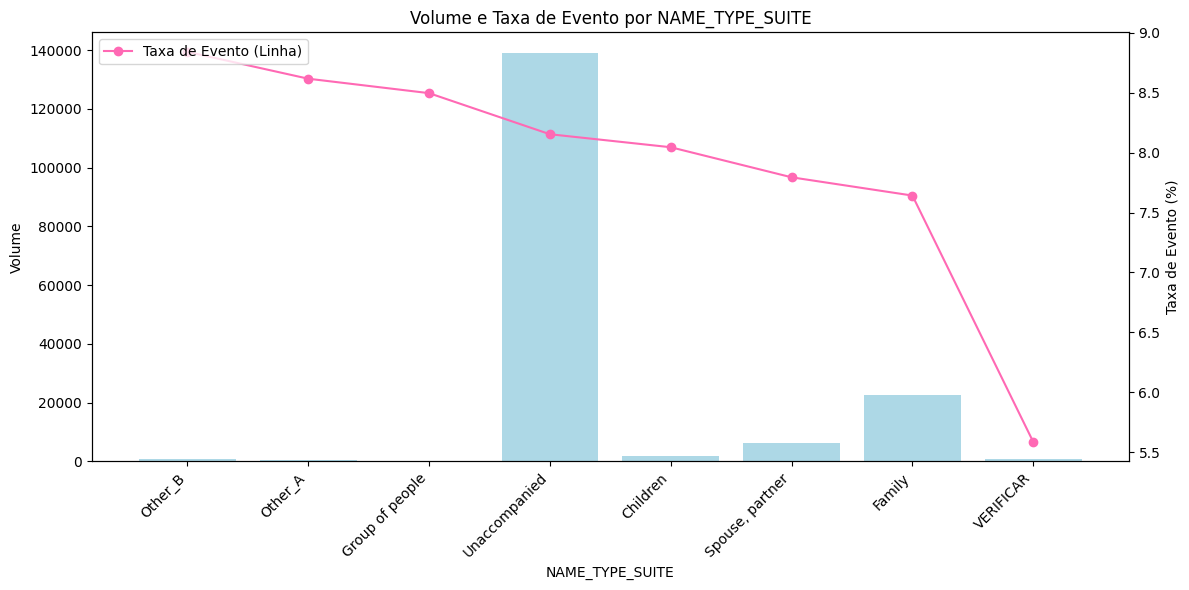

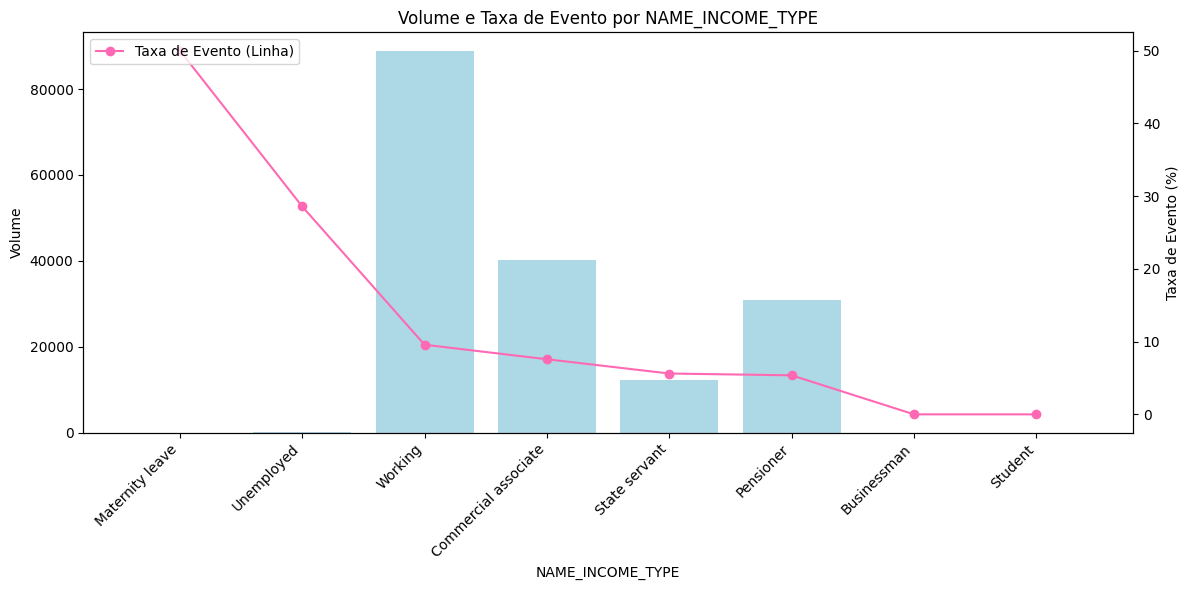

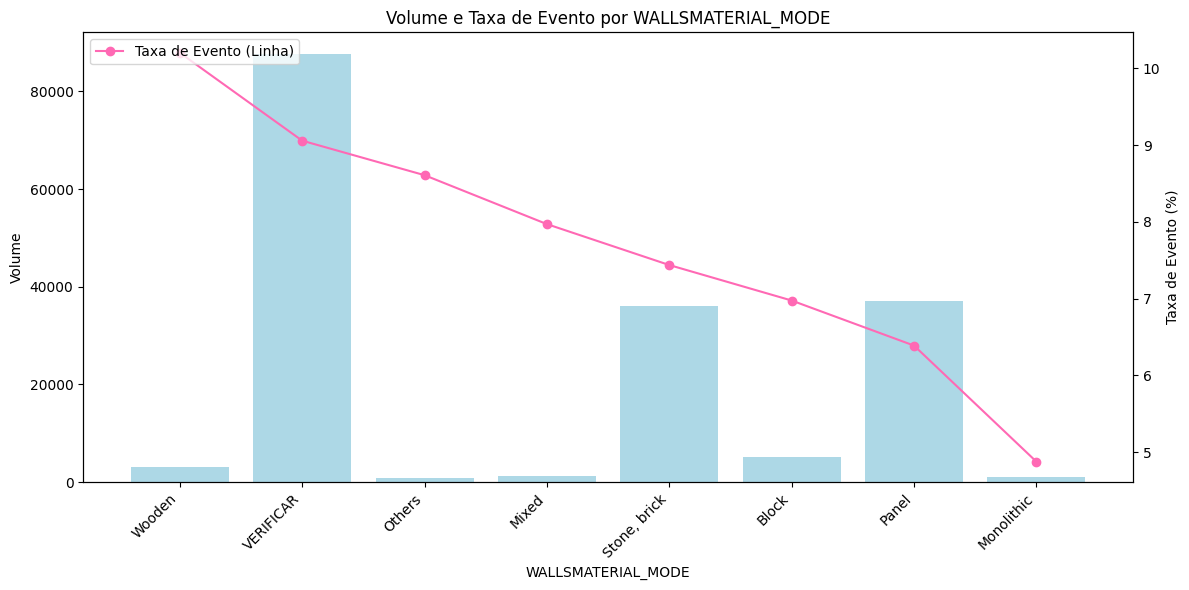

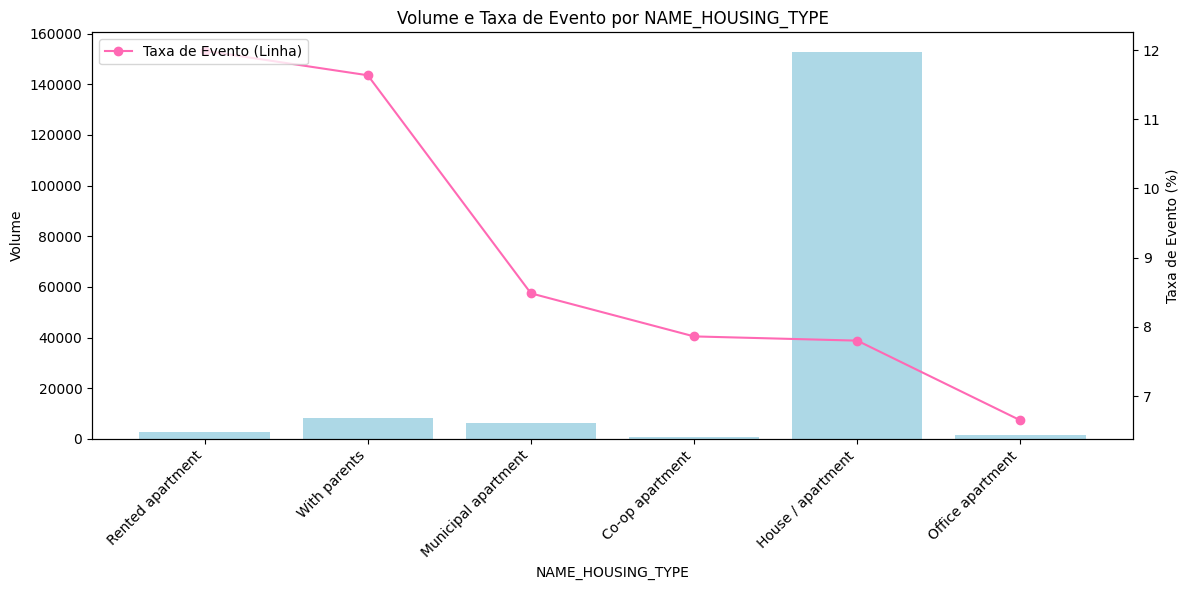

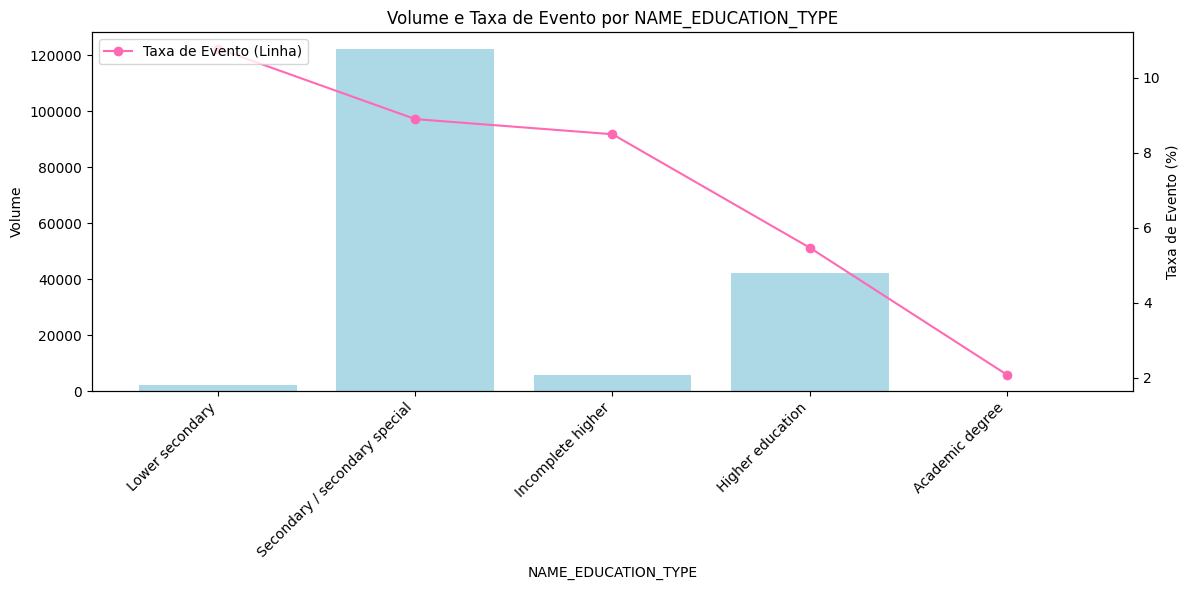

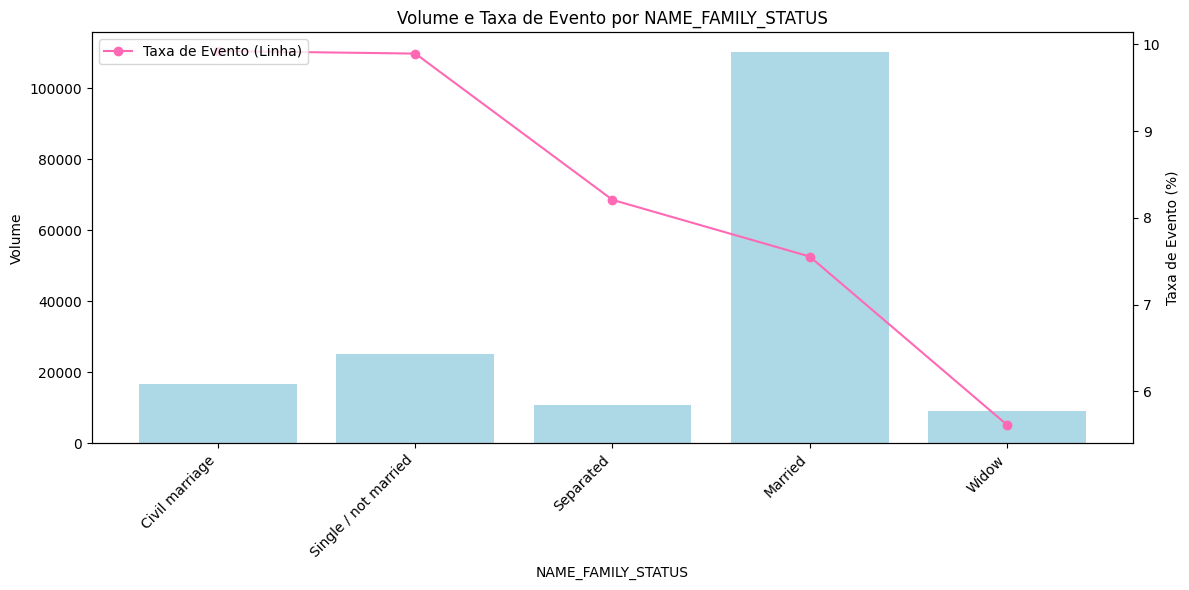

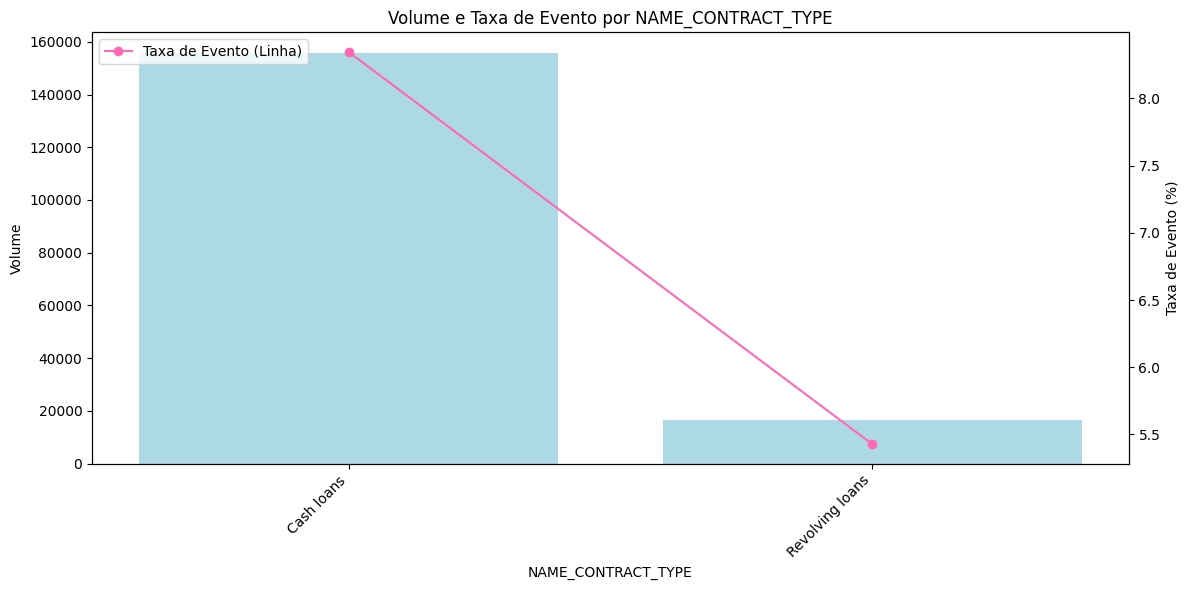

In [ ]:
# Chamando a função para analisar as variáveis.
for var in vars_ordinais:
  result = analyze_variable(abt_train_08, var, 'TARGET')

<br>

### **Agrupamento das categorias**

**Agrupando a variável NAME_INCOME_TYPE**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_08['NAME_INCOME_TYPE'].unique()
domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               'Working': 'Working',
               'Pensioner': 'Pensioner',
               'State servant': 'State servant',
               'Commercial associate': 'Commercial associate',
               'Student': 'Student',
               'Unemployed': 'Unemployed',
               'Businessman': 'Businessman',
               'Maternity leave': 'Maternity leave',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               'Working': 'Working',
               'Pensioner': 'Working',
               'State servant': 'Working',
               'Commercial associate': 'Working',
               'Student': 'Student',
               'Unemployed': 'Unemployed',
               'Businessman': 'Student',
               'Maternity leave': 'Maternity leave',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_08, 'TARGET', 'NAME_INCOME_TYPE', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_09 = apply_grouping(abt_train_08, transformation, 'NAME_INCOME_TYPE')

# Aplica nos dados de teste.
abt_test_09 = apply_grouping(abt_test_08, transformation, 'NAME_INCOME_TYPE')

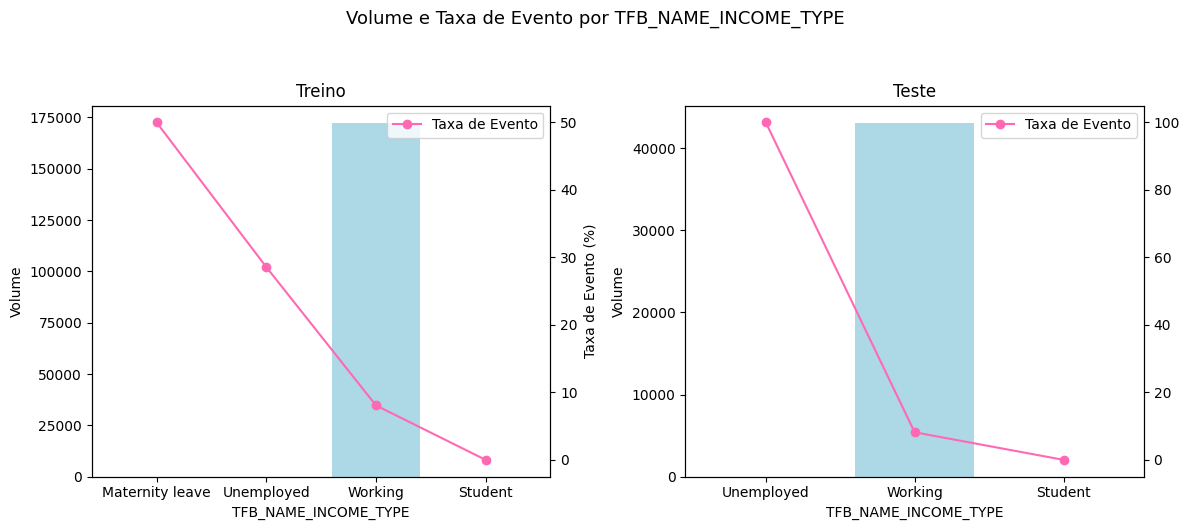

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_09, abt_test_09, 'TFB_NAME_INCOME_TYPE', 'TARGET')

<br>

**Agrupando a variável NAME_HOUSING_TYPE**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_09['NAME_HOUSING_TYPE'].unique()
domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               'House / apartment': 'House / apartment',
               'Rented apartment': 'Rented apartment',
               'Municipal apartment': 'Municipal apartment',
               'With parents': 'With parents',
               'Office apartment': 'Office apartment',
               'Co-op apartment': 'Co-op apartment',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               'House / apartment': 'Municipal apartment',
               'Rented apartment': 'Rented apartment',
               'Municipal apartment': 'Municipal apartment',
               'With parents': 'Rented apartment',
               'Office apartment': 'Office apartment',
               'Co-op apartment': 'Municipal apartment',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_09, 'TARGET', 'NAME_HOUSING_TYPE', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_10 = apply_grouping(abt_train_09, transformation, 'NAME_HOUSING_TYPE')

# Aplica nos dados de teste.
abt_test_10 = apply_grouping(abt_test_09, transformation, 'NAME_HOUSING_TYPE')

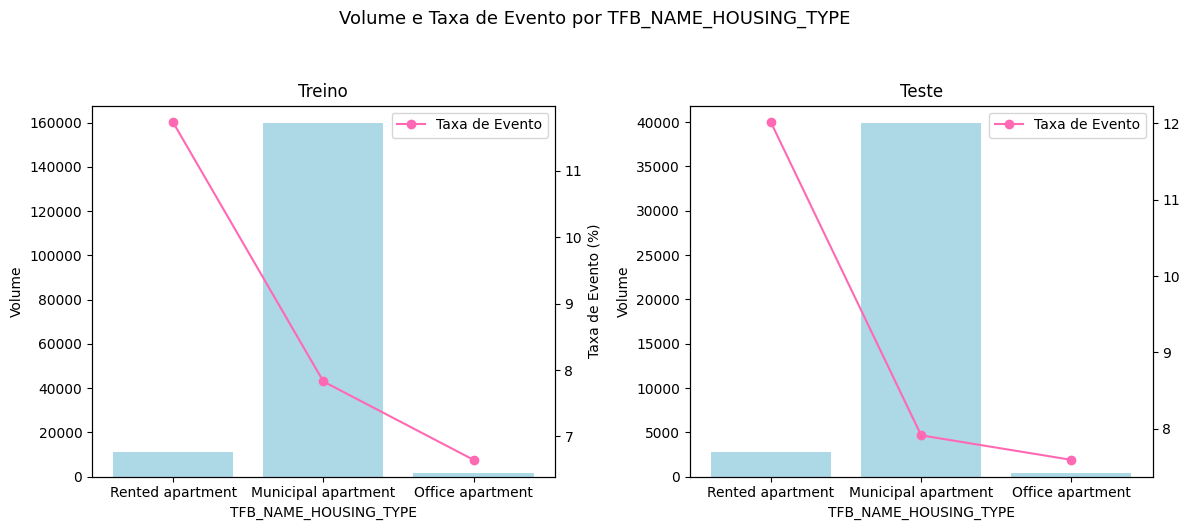

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_10, abt_test_10, 'TFB_NAME_HOUSING_TYPE', 'TARGET')

<br>

**Agrupando a variável NAME_EDUCATION_TYPE**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_10['NAME_EDUCATION_TYPE'].unique()
domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               'Secondary / secondary special': 'Secondary / secondary special',
               'Incomplete higher': 'Incomplete higher',
               'Higher education': 'Higher education',
               'Lower secondary': 'Lower secondary',
               'Academic degree': 'Academic degree',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               'Secondary / secondary special': 'Incomplete higher',
               'Incomplete higher': 'Incomplete higher',
               'Higher education': 'Higher education',
               'Lower secondary': 'Lower secondary',
               'Academic degree': 'Academic degree',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_10, 'TARGET', 'NAME_EDUCATION_TYPE', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_11 = apply_grouping(abt_train_10, transformation, 'NAME_EDUCATION_TYPE')

# Aplica nos dados de teste.
abt_test_11 = apply_grouping(abt_test_10, transformation, 'NAME_EDUCATION_TYPE')

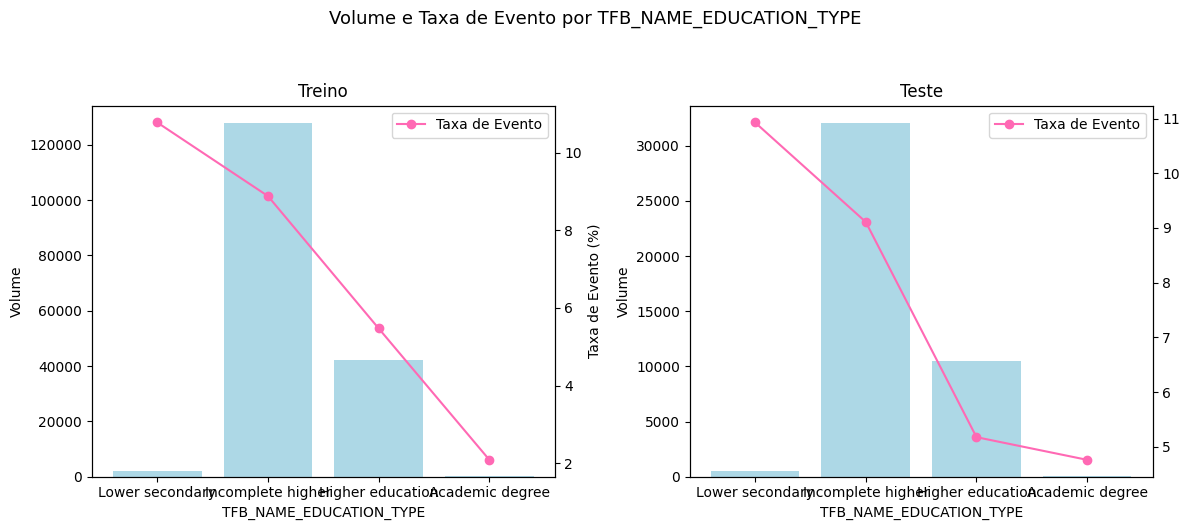

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_11, abt_test_11, 'TFB_NAME_EDUCATION_TYPE', 'TARGET')

<br>

**Agrupando a variável NAME_TYPE_SUITE**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_11['NAME_TYPE_SUITE'].unique()
domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               'Unaccompanied': 'Unaccompanied',
               'Spouse, partner': 'Spouse, partner',
               'Family': 'Family',
               'Children': 'Children',
               'Other_B': 'Other_B',
               'Group of people': 'Group of people',
               'VERIFICAR': 'VERIFICAR',
               'Other_A': 'Other_A',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               'Unaccompanied': 'Unaccompanied',
               'Spouse, partner': 'Spouse, partner',
               'Family': 'Spouse, partner',
               'Children': 'Unaccompanied',
               'Other_B': 'Other_B',
               'Group of people': 'Other_A',
               'VERIFICAR': 'VERIFICAR',
               'Other_A': 'Other_A',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_11, 'TARGET', 'NAME_TYPE_SUITE', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_12 = apply_grouping(abt_train_11, transformation, 'NAME_TYPE_SUITE')

# Aplica nos dados de teste.
abt_test_12 = apply_grouping(abt_test_11, transformation, 'NAME_TYPE_SUITE')

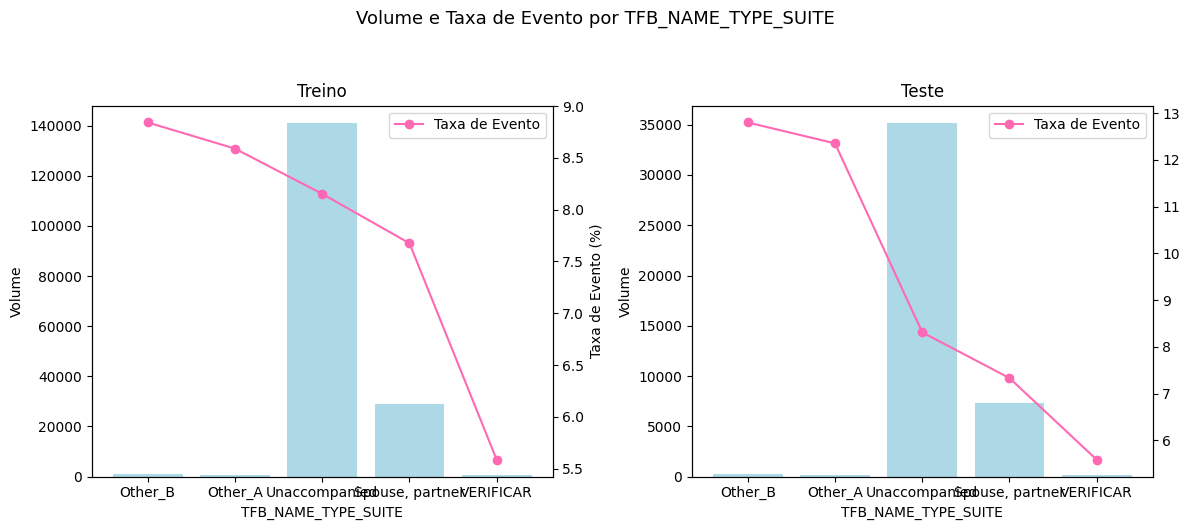

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_12, abt_test_12, 'TFB_NAME_TYPE_SUITE', 'TARGET')

<br>

**Agrupando a variável NAME_FAMILY_STATUS**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_12['NAME_FAMILY_STATUS'].unique()
domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               'Married': 'Married',
               'Separated': 'Separated',
               'Civil marriage': 'Civil marriage',
               'Single / not married': 'Single / not married',
               'Widow': 'Widow',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               'Married': 'Married',
               'Separated': 'Separated',
               'Civil marriage': 'Civil marriage',
               'Single / not married': 'Civil marriage',
               'Widow': 'Widow',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_12, 'TARGET', 'NAME_FAMILY_STATUS', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_13 = apply_grouping(abt_train_12, transformation, 'NAME_FAMILY_STATUS')

# Aplica nos dados de teste.
abt_test_13 = apply_grouping(abt_test_12, transformation, 'NAME_FAMILY_STATUS')

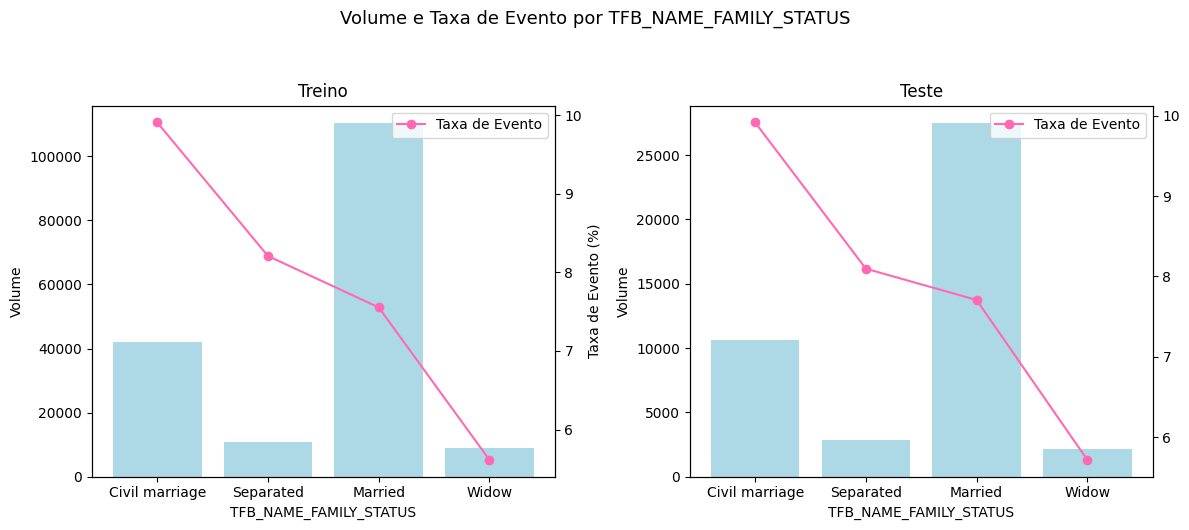

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_13, abt_test_13, 'TFB_NAME_FAMILY_STATUS', 'TARGET')

<br>
<br>
<br>
<br>

## **Categorização das variáveis numéricas**

Ao treinar um modelo de crédito, como a Regressão Logística, é importante categorizar as variáveis numéricas primeiro, por diversos motivos. Categorizar variáveis numéricas transforma-as em variáveis categóricas, tornando mais fácil interpretar o efeito dessas variáveis no modelo. Isso proporciona uma interpretabilidade mais clara, pois pode-se entender o impacto das variáveis em termos de grupos ou categorias, em vez de valores contínuos.
<br>
<br>
Além disso, a categorização pode capturar padrões não lineares que podem ser perdidos ao tratar as variáveis como contínuas. Por exemplo, a relação entre a idade e a probabilidade de inadimplência pode não ser linear, mas ao categorizar a idade em faixas etárias, é possível capturar melhor essa relação.
<br>
<br>
Por fim, categorizar variáveis pode tornar o modelo mais estável e melhorar o desempenho computacional. Modelos lineares, como a regressão logística, se beneficiam da categorização para melhor desempenho.

<br>

### **Variáveis numéricas de alta cardinalidade**

In [ ]:
# Checando as variáveis com cadinalidade maior que 15.
df_numericas = metadados_fs[(metadados_fs['CARDINALIDADE'] > 15) & (metadados_fs['USO_FEATURE']=='Explicativa')]
df_numericas

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
1,EXT_SOURCE_2,Explicativa,0,0.0,91216,float64
2,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,Explicativa,0,0.0,90199,float64
3,EXT_SOURCE_1,Explicativa,0,0.0,68723,float64
4,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,Explicativa,0,0.0,41559,float64
5,NEW_PAYMENT_RATE_APP_TRAIN,Explicativa,0,0.0,29971,float64
6,DAYS_BIRTH,Explicativa,0,0.0,17308,int64
7,AMT_ANNUITY,Explicativa,0,0.0,12297,float64
8,GOODS_CREDIT_RATIO_APP_TRAIN,Explicativa,0,0.0,2562,float64
9,EXT_SOURCE_3,Explicativa,0,0.0,791,float64
10,ORGANIZATION_TYPE,Explicativa,0,0.0,58,float64


In [ ]:
# Criando uma lista com as variáveis selecionadas.
vars_numericas = list(df_numericas.FEATURE)
vars_numericas

['EXT_SOURCE_2',
 'VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP',
 'EXT_SOURCE_1',
 'VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP',
 'NEW_PAYMENT_RATE_APP_TRAIN',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'GOODS_CREDIT_RATIO_APP_TRAIN',
 'EXT_SOURCE_3',
 'ORGANIZATION_TYPE',
 'OCCUPATION_TYPE']

<br>

**Categorizando a variável EXT_SOURCE_2**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_13, n_categories=5, target='TARGET', numeric_var='EXT_SOURCE_2')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
3,7,0.387424,493,-inf,0.006777
4,8,0.215790,7549,0.006802,0.125908
0,4,0.124571,32672,0.125927,0.378622
1,5,0.077130,66096,0.378632,0.616079
2,6,0.044407,65395,0.616084,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_14 = apply_tree_bins(abt_train_13, result, numeric_var='EXT_SOURCE_2')
abt_train_14.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2
0,-19489,0.758916,0.510090,1.000000,0.054453,34060.5,4994.550000,4994.550000,0,Cash loans,0.063887,0.096493,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3
1,-21070,0.502984,0.367291,0.677879,0.051519,14364.0,7911.140000,1076.580000,0,Cash loans,0.105932,0.092509,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4
2,-11513,0.287588,0.150085,1.000000,0.106093,20529.0,20029.939481,11432.662661,0,Cash loans,0.063887,0.092509,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4
3,-21850,0.502984,0.510966,1.000000,0.056800,7668.0,20029.939481,6.980000,0,Cash loans,0.065004,0.053759,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2
4,-13273,0.502984,0.490258,0.873210,0.029340,37800.0,20029.939481,8649.270000,0,Cash loans,0.115646,0.092509,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_14 = apply_tree_bins(abt_test_13, result, numeric_var='EXT_SOURCE_2')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_14.TFT_EXT_SOURCE_2.unique()

array([3, 4, 2, 1, 0])

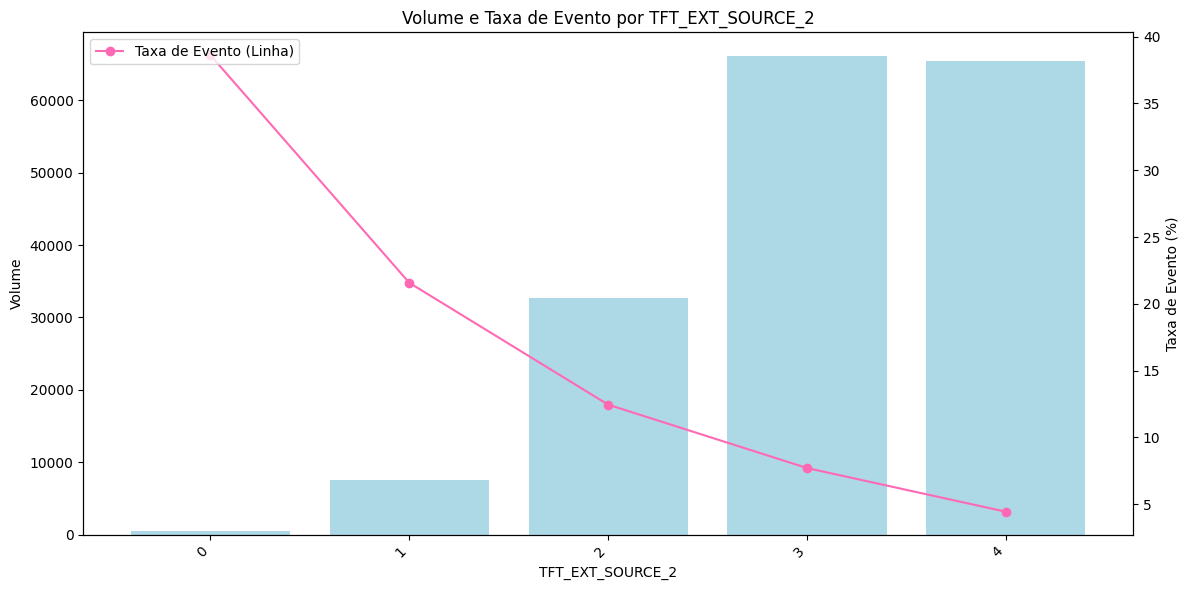

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_14, 'TFT_EXT_SOURCE_2', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_EXT_SOURCE_2,Taxa_de_Evento,Volume
0,0,0.386179,492
1,1,0.215790,7549
2,2,0.124571,32672
3,3,0.077133,66094
4,4,0.044420,65398


<br>

**Categorizando a variável VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_14, n_categories=5, target='TARGET', numeric_var='VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
2,5,0.132720,23787,-inf,94.05
3,7,0.104548,22210,94.10,2128.68
4,8,0.600000,5,2129.40,2130.12
0,3,0.072244,87772,2130.30,11564.55
1,4,0.053837,38431,11564.64,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_15 = apply_tree_bins(abt_train_14, result, numeric_var='VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP')
abt_train_15.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP
0,-19489,0.758916,0.510090,1.000000,0.054453,34060.5,4994.550000,0,Cash loans,0.063887,0.096493,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,3
1,-21070,0.502984,0.367291,0.677879,0.051519,14364.0,7911.140000,0,Cash loans,0.105932,0.092509,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,1
2,-11513,0.287588,0.150085,1.000000,0.106093,20529.0,20029.939481,0,Cash loans,0.063887,0.092509,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,3
3,-21850,0.502984,0.510966,1.000000,0.056800,7668.0,20029.939481,0,Cash loans,0.065004,0.053759,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0
4,-13273,0.502984,0.490258,0.873210,0.029340,37800.0,20029.939481,0,Cash loans,0.115646,0.092509,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,3


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_15 = apply_tree_bins(abt_test_14, result, numeric_var='VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_15.TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP.unique()

array([3, 1, 0, 4, 2])

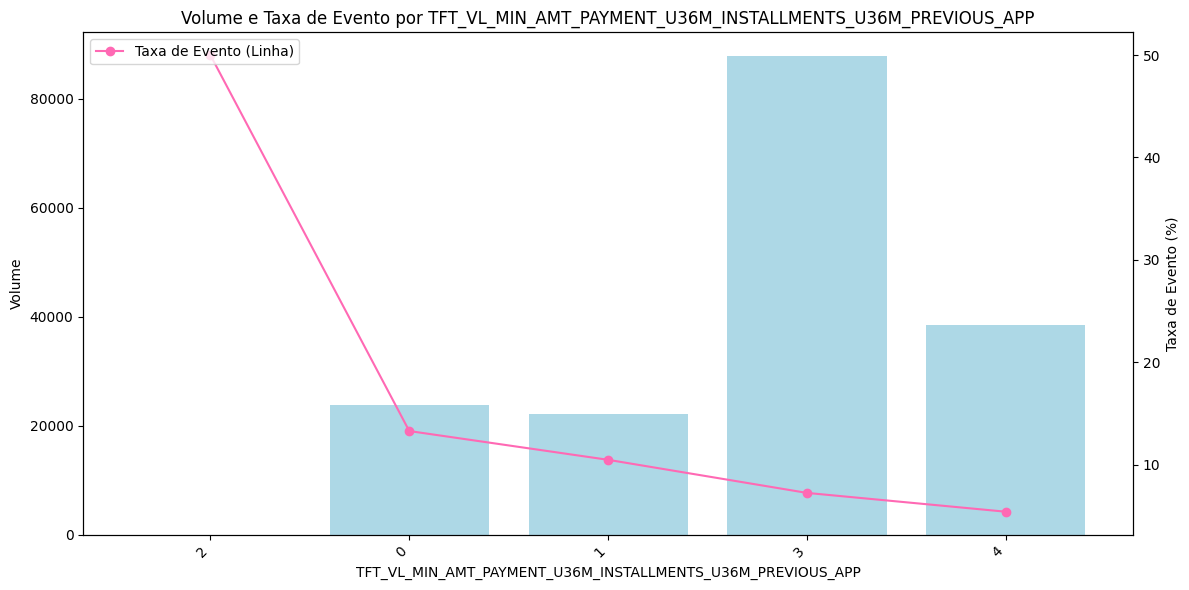

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_15, 'TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,Taxa_de_Evento,Volume
2,2,0.500000,4
0,0,0.132694,23784
1,1,0.104583,22212
3,3,0.072243,87773
4,4,0.053861,38432


**Agrupando a variável TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_15['TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP'].unique()

domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               '3': '3',
               '1': '1',
               '0': '0',
               '4': '4',
               '2': '2',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               '3': '4',
               '1': '0',
               '0': '0',
               '4': '4',
               '2': '2',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_15, 'TARGET', 'TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_16 = apply_grouping(abt_train_15, transformation, 'TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP')

# Aplica nos dados de teste.
abt_test_16 = apply_grouping(abt_test_15, transformation, 'TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP')

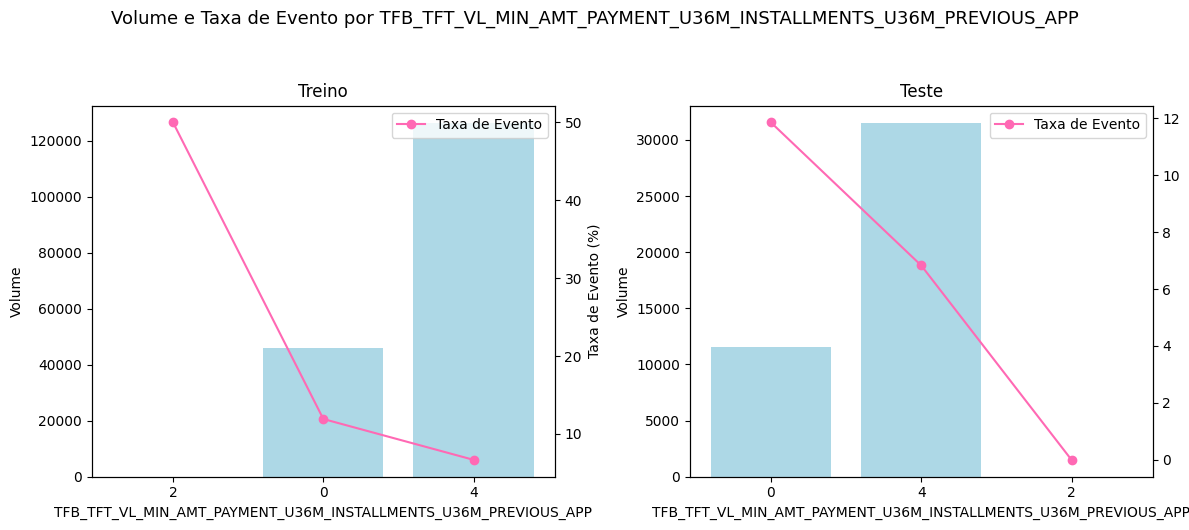

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_16, abt_test_16, 'TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP', 'TARGET')

<br>

**Categorizando a variável EXT_SOURCE_1**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_16, n_categories=5, target='TARGET', numeric_var='EXT_SOURCE_1')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
3,7,0.419847,131,-inf,0.044119
4,8,0.223529,1700,0.044140,0.120643
2,6,0.142871,10254,0.120656,0.265402
0,3,0.083570,129029,0.265403,0.565590
1,4,0.038886,31091,0.565609,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_17 = apply_tree_bins(abt_train_16, result, numeric_var='EXT_SOURCE_1')
abt_train_17.head()

,DAYS_BIRTH,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1
0,-19489,0.510090,1.000000,0.054453,34060.5,4994.550000,0,Cash loans,0.063887,0.096493,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4
1,-21070,0.367291,0.677879,0.051519,14364.0,7911.140000,0,Cash loans,0.105932,0.092509,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3
2,-11513,0.150085,1.000000,0.106093,20529.0,20029.939481,0,Cash loans,0.063887,0.092509,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3
3,-21850,0.510966,1.000000,0.056800,7668.0,20029.939481,0,Cash loans,0.065004,0.053759,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3
4,-13273,0.490258,0.873210,0.029340,37800.0,20029.939481,0,Cash loans,0.115646,0.092509,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_17 = apply_tree_bins(abt_test_16, result, numeric_var='EXT_SOURCE_1')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_17.TFT_EXT_SOURCE_1.unique()

array([4, 3, 2, 1, 0])

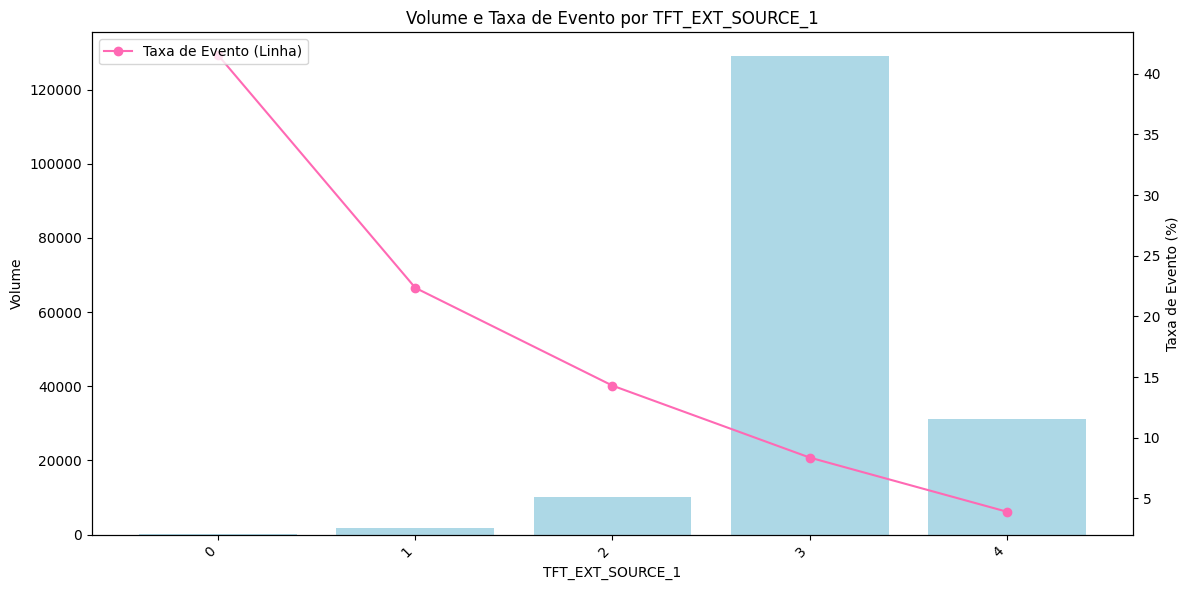

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_17, 'TFT_EXT_SOURCE_1', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_EXT_SOURCE_1,Taxa_de_Evento,Volume
0,0,0.415385,130
1,1,0.223529,1700
2,2,0.142871,10254
3,3,0.083570,129029
4,4,0.038917,31092


<br>

**Categorizando a variável NEW_PAYMENT_RATE_APP_TRAIN**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_17, n_categories=5, target='TARGET', numeric_var='NEW_PAYMENT_RATE_APP_TRAIN')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,1,0.062452,69686,-inf,0.046604
1,3,0.148005,14459,0.046605,0.049731
3,7,0.083871,61201,0.049763,0.078814
4,8,0.162250,8339,0.078820,0.092491
2,6,0.049352,18520,0.092493,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_18 = apply_tree_bins(abt_train_17, result, numeric_var='NEW_PAYMENT_RATE_APP_TRAIN')
abt_train_18.head()

,DAYS_BIRTH,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TARGET,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFT_NEW_PAYMENT_RATE_APP_TRAIN
0,-19489,0.510090,1.000000,34060.5,4994.550000,0,Cash loans,0.063887,0.096493,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2
1,-21070,0.367291,0.677879,14364.0,7911.140000,0,Cash loans,0.105932,0.092509,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2
2,-11513,0.150085,1.000000,20529.0,20029.939481,0,Cash loans,0.063887,0.092509,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4
3,-21850,0.510966,1.000000,7668.0,20029.939481,0,Cash loans,0.065004,0.053759,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2
4,-13273,0.490258,0.873210,37800.0,20029.939481,0,Cash loans,0.115646,0.092509,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_18 = apply_tree_bins(abt_test_17, result, numeric_var='NEW_PAYMENT_RATE_APP_TRAIN')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_18.TFT_NEW_PAYMENT_RATE_APP_TRAIN.unique()

array([2, 4, 0, 1, 3])

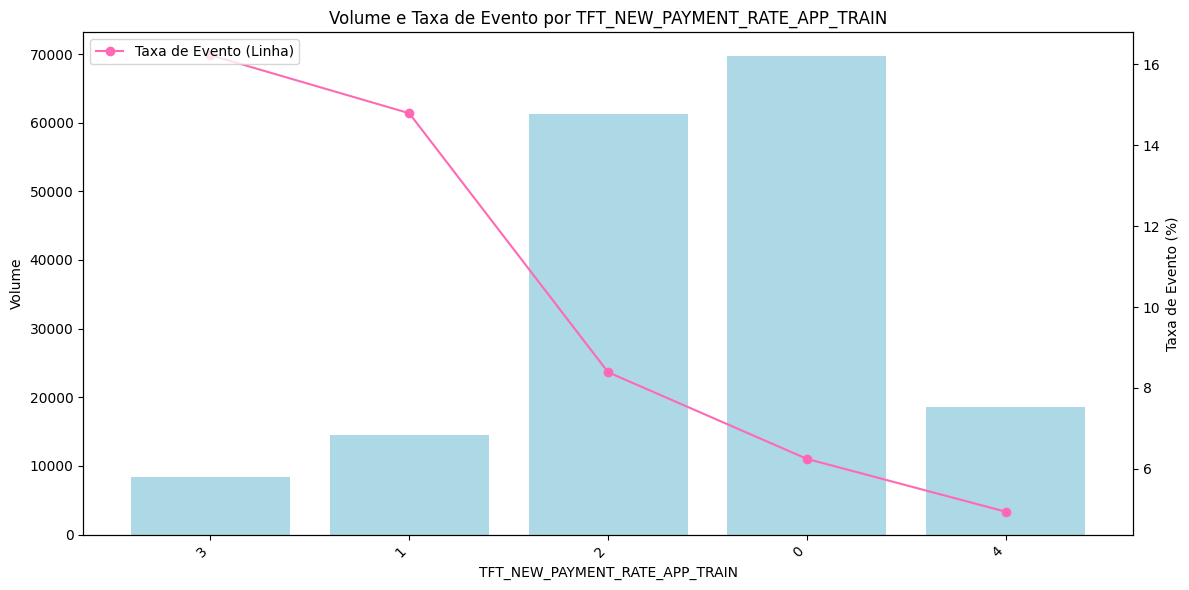

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_18, 'TFT_NEW_PAYMENT_RATE_APP_TRAIN', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_NEW_PAYMENT_RATE_APP_TRAIN,Taxa_de_Evento,Volume
3,3,0.162305,8330
1,1,0.147936,14459
2,2,0.083888,61201
0,0,0.062452,69685
4,4,0.049379,18530


**Agrupando a variável TFT_NEW_PAYMENT_RATE_APP_TRAIN**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_18['TFT_NEW_PAYMENT_RATE_APP_TRAIN'].unique()

domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               '2': '2',
               '4': '4',
               '0': '0',
               '1': '1',
               '3': '3',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               '2': '2',
               '4': '4',
               '0': '0',
               '1': '3',
               '3': '3',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_18, 'TARGET', 'TFT_NEW_PAYMENT_RATE_APP_TRAIN', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_19 = apply_grouping(abt_train_18, transformation, 'TFT_NEW_PAYMENT_RATE_APP_TRAIN')

# Aplica nos dados de teste.
abt_test_19 = apply_grouping(abt_test_18, transformation, 'TFT_NEW_PAYMENT_RATE_APP_TRAIN')

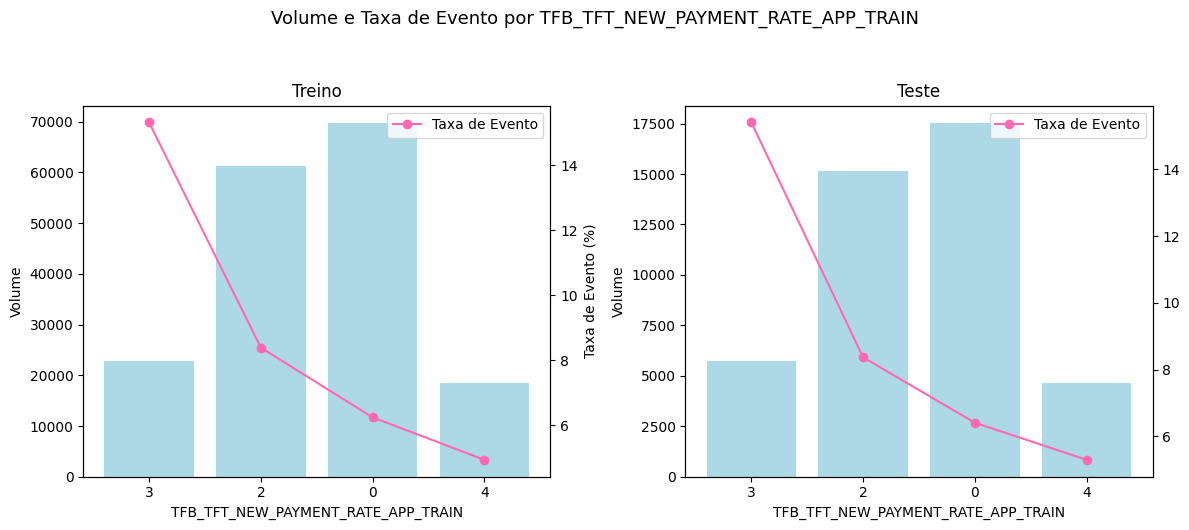

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_19, abt_test_19, 'TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN', 'TARGET')

<br>

**Categorizando a variável VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_19, n_categories=5, target='TARGET', numeric_var='VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
1,5,0.186248,3694,-inf,97.43
2,6,0.146674,5202,97.52,1524.15
3,7,0.100876,3083,1524.29,3550.10
4,8,0.077654,148608,3550.77,20099.97
0,4,0.050783,11618,20100.15,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_20 = apply_tree_bins(abt_train_19, result, numeric_var='VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP')
abt_train_20.head()

,DAYS_BIRTH,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,AMT_ANNUITY,TARGET,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP
0,-19489,0.510090,1.000000,34060.5,0,Cash loans,0.063887,0.096493,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3
1,-21070,0.367291,0.677879,14364.0,0,Cash loans,0.105932,0.092509,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3
2,-11513,0.150085,1.000000,20529.0,0,Cash loans,0.063887,0.092509,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3
3,-21850,0.510966,1.000000,7668.0,0,Cash loans,0.065004,0.053759,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3
4,-13273,0.490258,0.873210,37800.0,0,Cash loans,0.115646,0.092509,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_20 = apply_tree_bins(abt_test_19, result, numeric_var='VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_20.TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP.unique()

array([3, 4, 1, 0, 2])

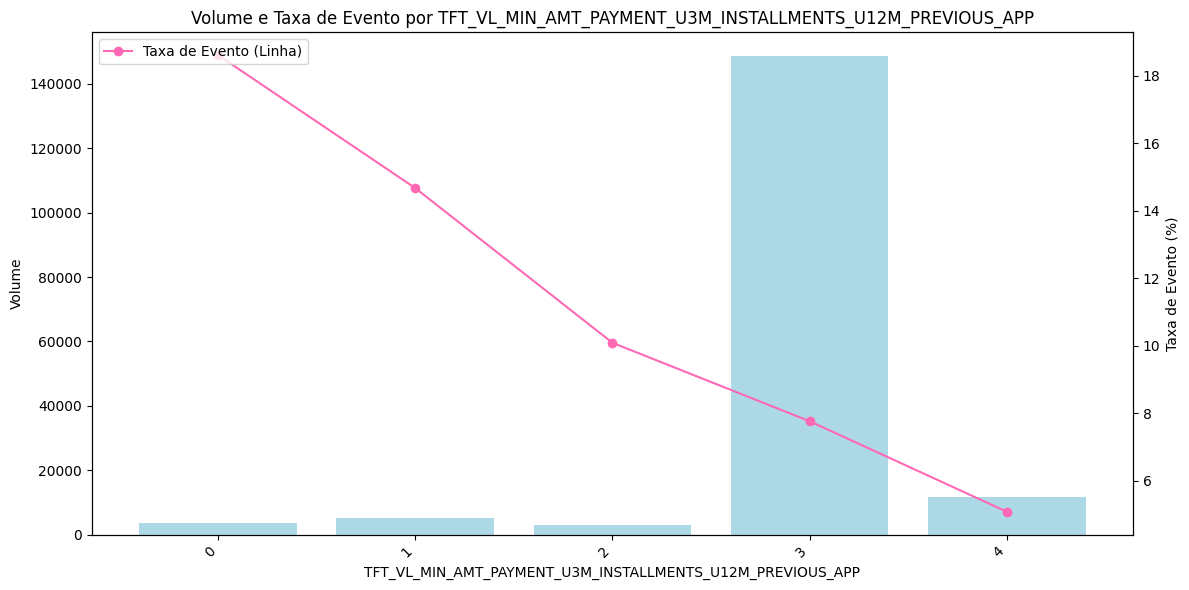

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_20, 'TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,Taxa_de_Evento,Volume
0,0,0.186028,3693
1,1,0.146674,5202
2,2,0.100876,3083
3,3,0.077654,148608
4,4,0.050865,11619


<br>

**Categorizando a variável EXT_SOURCE_3**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_20, n_categories=5, target='TARGET', numeric_var='EXT_SOURCE_3')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
3,7,0.292338,2049,-inf,0.080650
4,8,0.221463,4100,0.081186,0.145543
2,6,0.147478,19169,0.146442,0.315472
0,3,0.088023,72470,0.317032,0.511892
1,4,0.042719,74417,0.513694,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_21 = apply_tree_bins(abt_train_20, result, numeric_var='EXT_SOURCE_3')
abt_train_21.head()

,DAYS_BIRTH,GOODS_CREDIT_RATIO_APP_TRAIN,AMT_ANNUITY,TARGET,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3
0,-19489,1.000000,34060.5,0,Cash loans,0.063887,0.096493,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3
1,-21070,0.677879,14364.0,0,Cash loans,0.105932,0.092509,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3
2,-11513,1.000000,20529.0,0,Cash loans,0.063887,0.092509,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2
3,-21850,1.000000,7668.0,0,Cash loans,0.065004,0.053759,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3
4,-13273,0.873210,37800.0,0,Cash loans,0.115646,0.092509,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_21 = apply_tree_bins(abt_test_20, result, numeric_var='EXT_SOURCE_3')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_21.TFT_EXT_SOURCE_3.unique()

array([3, 2, 4, 0, 1])

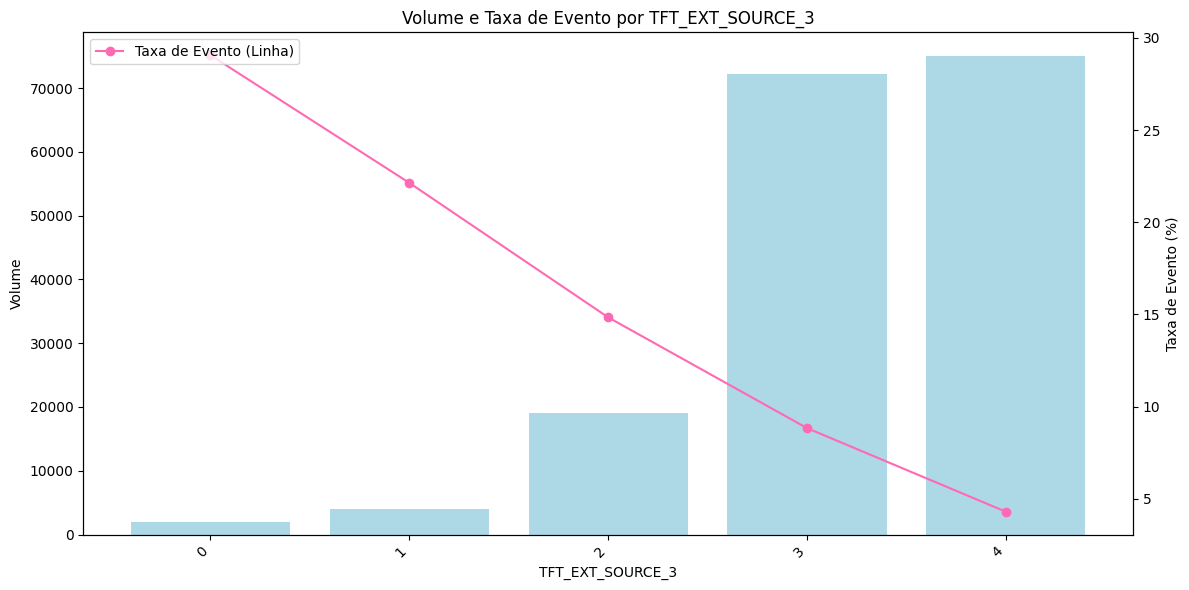

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_21, 'TFT_EXT_SOURCE_3', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_EXT_SOURCE_3,Taxa_de_Evento,Volume
0,0,0.290640,2030
1,1,0.221368,4034
2,2,0.148394,19017
3,3,0.088290,72137
4,4,0.042914,74987


<br>

**Categorizando a variável ORGANIZATION_TYPE**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_21, n_categories=5, target='TARGET', numeric_var='ORGANIZATION_TYPE')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,3,0.053338,42896,-inf,0.058165
1,4,0.070330,32703,0.064272,0.075671
3,7,0.090382,53639,0.079882,0.093282
4,8,0.099434,31076,0.093785,0.101895
2,6,0.114877,11891,0.105350,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_22 = apply_tree_bins(abt_train_21, result, numeric_var='ORGANIZATION_TYPE')
abt_train_22.head()

,DAYS_BIRTH,GOODS_CREDIT_RATIO_APP_TRAIN,AMT_ANNUITY,TARGET,NAME_CONTRACT_TYPE,OCCUPATION_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE
0,-19489,1.000000,34060.5,0,Cash loans,0.063887,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3,3
1,-21070,0.677879,14364.0,0,Cash loans,0.105932,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3,2
2,-11513,1.000000,20529.0,0,Cash loans,0.063887,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2,2
3,-21850,1.000000,7668.0,0,Cash loans,0.065004,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3,0
4,-13273,0.873210,37800.0,0,Cash loans,0.115646,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3,2


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_22 = apply_tree_bins(abt_test_21, result, numeric_var='ORGANIZATION_TYPE')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_22.TFT_ORGANIZATION_TYPE.unique()

array([3, 2, 0, 1, 4])

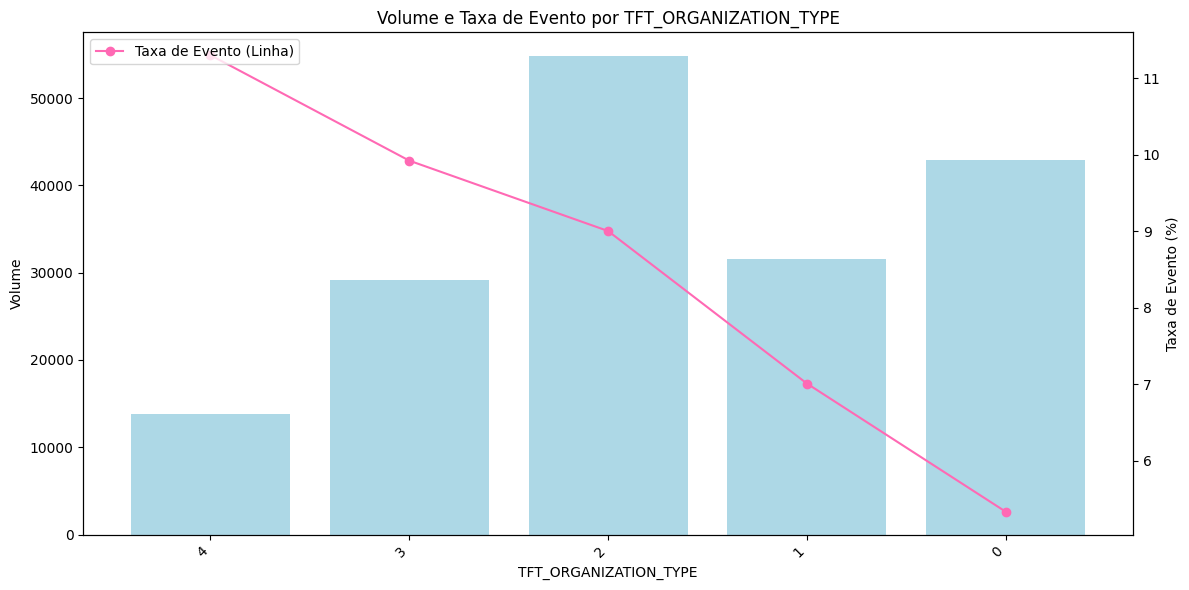

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_22, 'TFT_ORGANIZATION_TYPE', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_ORGANIZATION_TYPE,Taxa_de_Evento,Volume
4,4,0.113045,13844
3,3,0.099253,29198
2,2,0.090048,54793
1,1,0.070103,31511
0,0,0.053338,42859


<br>

**Categorizando a variável OCCUPATION_TYPE**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_22, n_categories=5, target='TARGET', numeric_var='OCCUPATION_TYPE')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
3,7,0.048887,5482,-inf,0.048887
4,8,0.064443,95929,0.059748,0.070922
1,5,0.096141,17880,0.096141,0.096141
2,6,0.106763,51750,0.102986,0.115646
0,4,0.170103,1164,0.170103,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_23 = apply_tree_bins(abt_train_22, result, numeric_var='OCCUPATION_TYPE')
abt_train_23.head()

,DAYS_BIRTH,GOODS_CREDIT_RATIO_APP_TRAIN,AMT_ANNUITY,TARGET,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE,TFT_OCCUPATION_TYPE
0,-19489,1.000000,34060.5,0,Cash loans,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3,3,1
1,-21070,0.677879,14364.0,0,Cash loans,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3,2,3
2,-11513,1.000000,20529.0,0,Cash loans,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2,2,1
3,-21850,1.000000,7668.0,0,Cash loans,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3,0,1
4,-13273,0.873210,37800.0,0,Cash loans,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3,2,4


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_23 = apply_tree_bins(abt_test_22, result, numeric_var='OCCUPATION_TYPE')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_23.TFT_OCCUPATION_TYPE.unique()

array([1, 3, 4, 2])

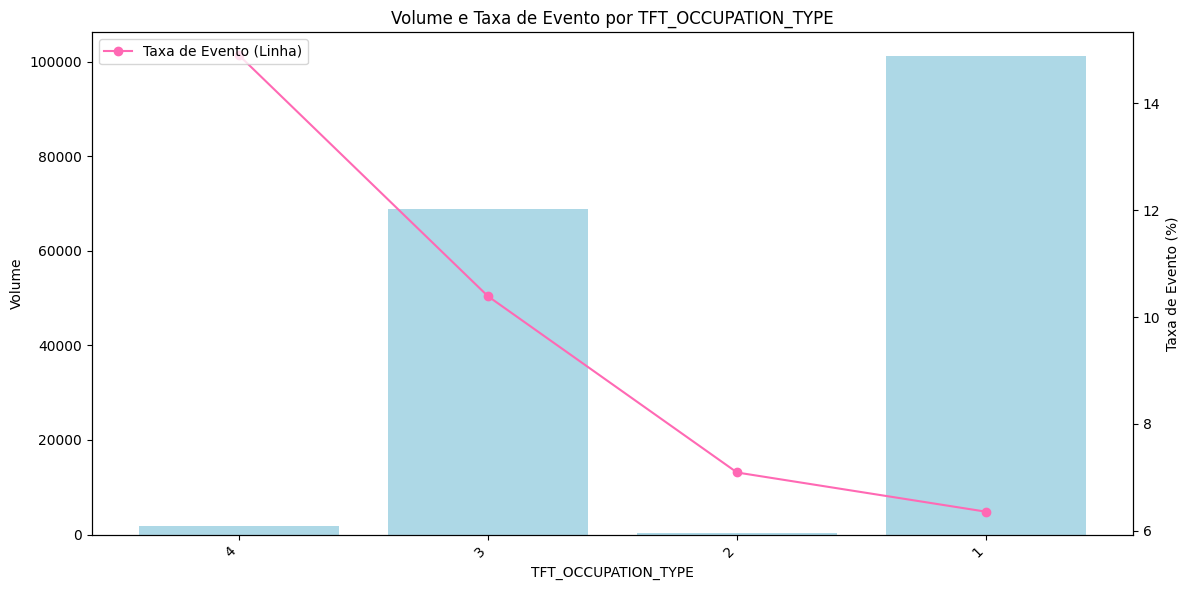

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_23, 'TFT_OCCUPATION_TYPE', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_OCCUPATION_TYPE,Taxa_de_Evento,Volume
3,4,0.149026,1899
2,3,0.103912,68895
1,2,0.070922,282
0,1,0.063582,101129


**Agrupando a variável TFT_OCCUPATION_TYPE**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_23['TFT_OCCUPATION_TYPE'].unique()

domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               '1': '1',
               '3': '3',
               '4': '4',
               '2': '2',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               '1': '1',
               '3': '3',
               '4': '4',
               '2': '1',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_23, 'TARGET', 'TFT_OCCUPATION_TYPE', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_24 = apply_grouping(abt_train_23, transformation, 'TFT_OCCUPATION_TYPE')

# Aplica nos dados de teste.
abt_test_24 = apply_grouping(abt_test_23, transformation, 'TFT_OCCUPATION_TYPE')

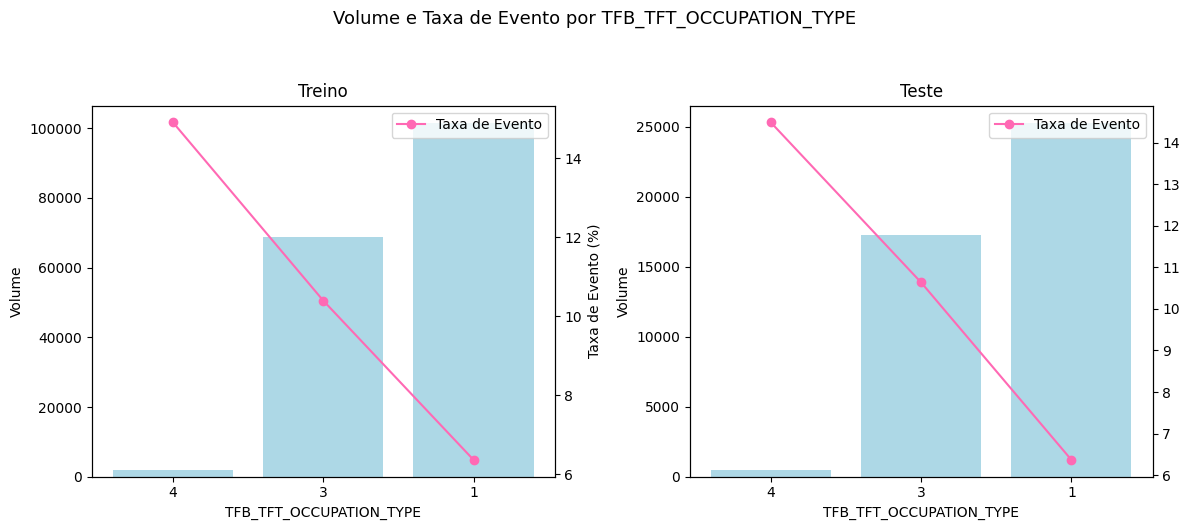

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_24, abt_test_24, 'TFB_TFT_OCCUPATION_TYPE', 'TARGET')

<br>

**Categorizando a variável DAYS_BIRTH**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_24, n_categories=5, target='TARGET', numeric_var='DAYS_BIRTH')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,3,0.052181,39171,-inf,-20008.0
1,4,0.074267,65238,-20007.0,-14344.0
2,5,0.094138,38794,-14343.0,-11280.0
3,7,0.112424,24879,-11279.0,-8680.0
4,8,0.134368,4123,-8679.0,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_25 = apply_tree_bins(abt_train_24, result, numeric_var='DAYS_BIRTH')
abt_train_25.head()

,GOODS_CREDIT_RATIO_APP_TRAIN,AMT_ANNUITY,TARGET,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE,TFB_TFT_OCCUPATION_TYPE,TFT_DAYS_BIRTH
0,1.000000,34060.5,0,Cash loans,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3,3,1,1
1,0.677879,14364.0,0,Cash loans,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3,2,3,0
2,1.000000,20529.0,0,Cash loans,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2,2,1,2
3,1.000000,7668.0,0,Cash loans,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3,0,1,0
4,0.873210,37800.0,0,Cash loans,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3,2,4,2


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_25 = apply_tree_bins(abt_test_24, result, numeric_var='DAYS_BIRTH')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_25.TFT_DAYS_BIRTH.unique()

array([1, 0, 2, 3, 4])

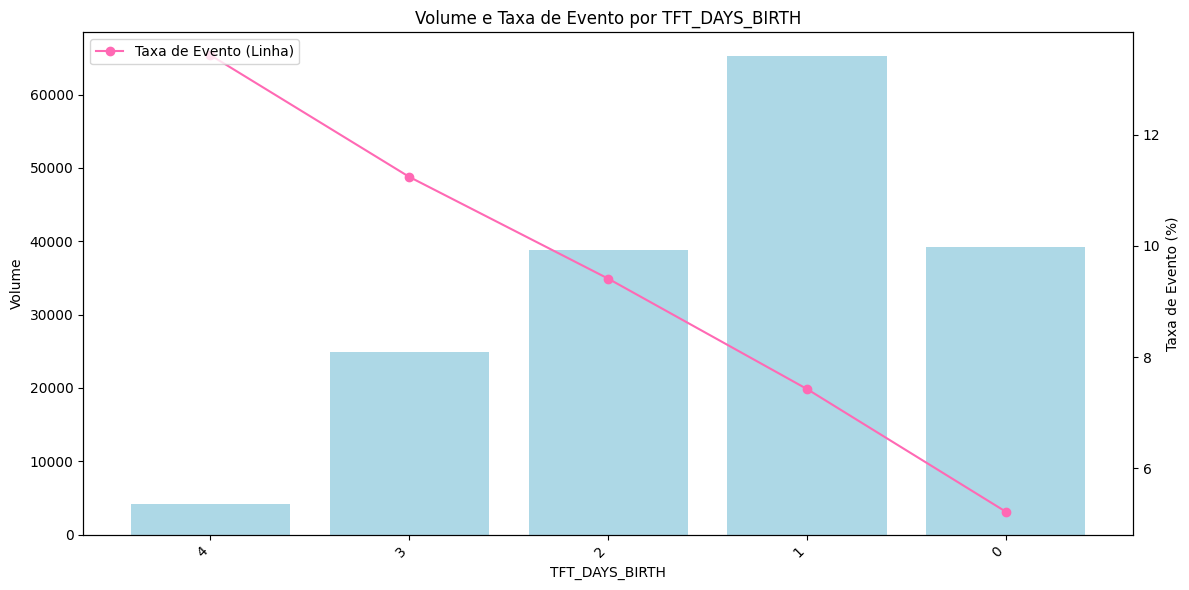

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_25, 'TFT_DAYS_BIRTH', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_DAYS_BIRTH,Taxa_de_Evento,Volume
4,4,0.134303,4125
3,3,0.112410,24891
2,2,0.094117,38792
1,1,0.074265,65239
0,0,0.052199,39158


<br>

**Categorizando a variável AMT_ANNUITY**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_25, n_categories=5, target='TARGET', numeric_var='AMT_ANNUITY')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
0,3,0.069549,42833,-inf,16483.5
3,7,0.090650,93833,16488.0,37102.5
4,8,0.078869,15811,37107.0,44676.0
1,5,0.064855,16005,44680.5,62653.5
2,6,0.032769,3723,62658.0,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_26 = apply_tree_bins(abt_train_25, result, numeric_var='AMT_ANNUITY')
abt_train_26.head()

,GOODS_CREDIT_RATIO_APP_TRAIN,TARGET,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE,TFB_TFT_OCCUPATION_TYPE,TFT_DAYS_BIRTH,TFT_AMT_ANNUITY
0,1.000000,0,Cash loans,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3,3,1,1,1
1,0.677879,0,Cash loans,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3,2,3,0,0
2,1.000000,0,Cash loans,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2,2,1,2,1
3,1.000000,0,Cash loans,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3,0,1,0,0
4,0.873210,0,Cash loans,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3,2,4,2,2


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_26 = apply_tree_bins(abt_test_25, result, numeric_var='AMT_ANNUITY')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_26.TFT_AMT_ANNUITY.unique()

array([1, 0, 2, 4, 3])

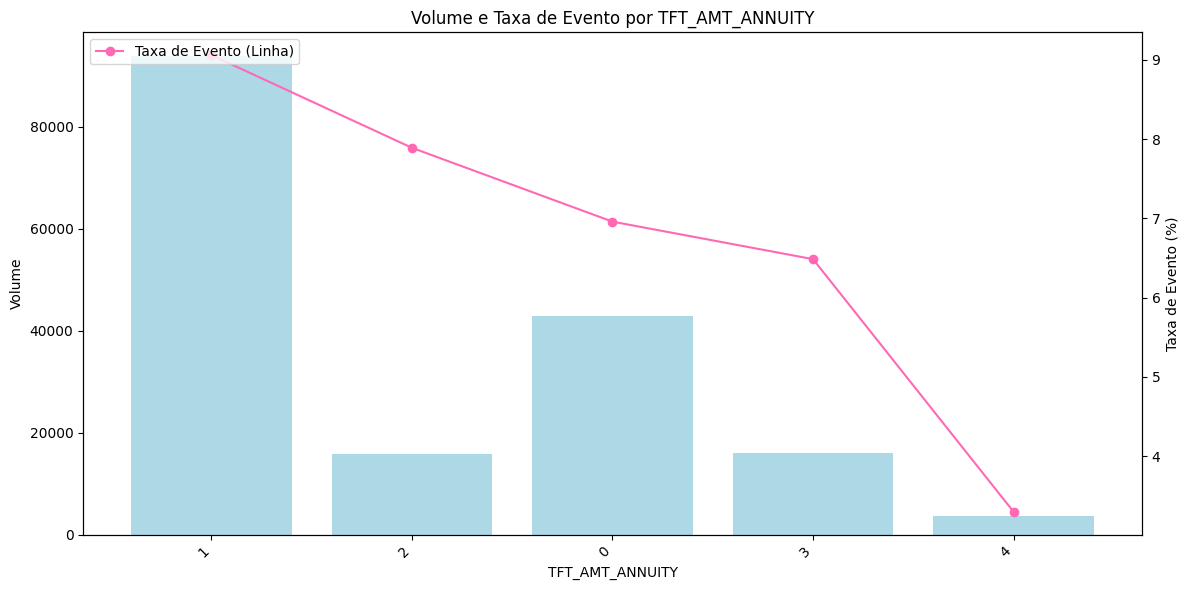

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_26, 'TFT_AMT_ANNUITY', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_AMT_ANNUITY,Taxa_de_Evento,Volume
1,1,0.090606,93857
2,2,0.078912,15815
0,0,0.069598,42803
3,3,0.064867,16002
4,4,0.032994,3728


**Agrupando a variável TFT_AMT_ANNUITY**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_26['TFT_AMT_ANNUITY'].unique()

domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               '1': '1',
               '0': '0',
               '2': '2',
               '4': '4',
               '3': '3',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               '1': '1',
               '0': '3',
               '2': '2',
               '4': '4',
               '3': '3',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_26, 'TARGET', 'TFT_AMT_ANNUITY', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_27 = apply_grouping(abt_train_26, transformation, 'TFT_AMT_ANNUITY')

# Aplica nos dados de teste.
abt_test_27 = apply_grouping(abt_test_26, transformation, 'TFT_AMT_ANNUITY')

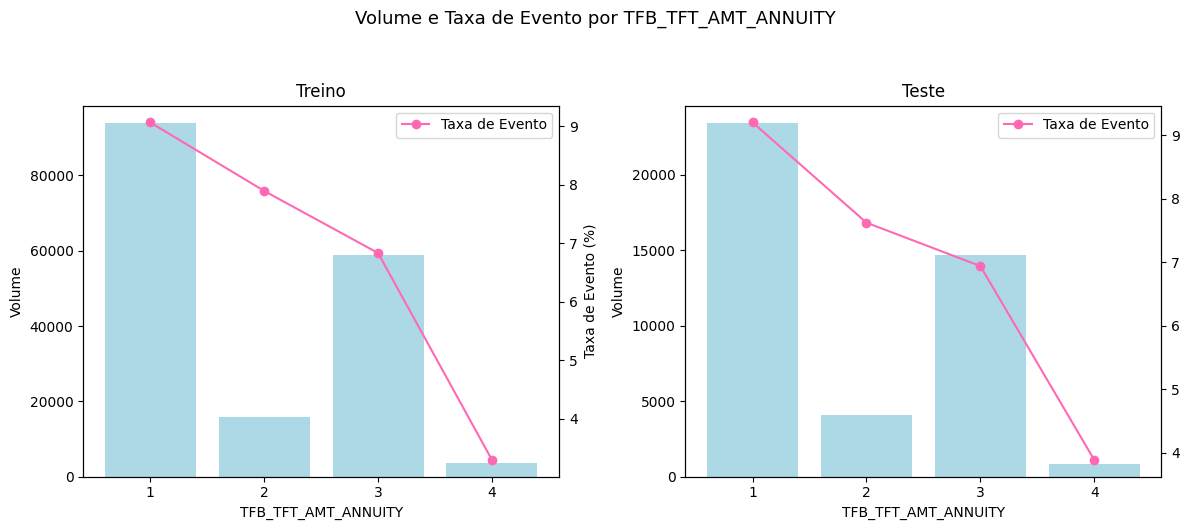

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_27, abt_test_27, 'TFB_TFT_AMT_ANNUITY', 'TARGET')

<br>

**Categorizando a variável GOODS_CREDIT_RATIO_APP_TRAIN**

In [ ]:
# Chamando a função para categorizar a variável.
result = categorize_with_decision_tree(abt_train_27, n_categories=5, target='TARGET', numeric_var='GOODS_CREDIT_RATIO_APP_TRAIN')
result

,Leaf,Taxa_de_Evento,Volume,Lower_Bound,Upper_Bound
3,7,0.114872,1802,-inf,0.690228
4,8,0.175421,3027,0.690229,0.703041
2,6,0.111409,31290,0.714286,0.825632
0,3,0.089521,25413,0.825633,0.863260
1,4,0.066800,110673,0.863260,inf


In [ ]:
# Chamando a função para a criação das faixas.
abt_train_28 = apply_tree_bins(abt_train_27, result, numeric_var='GOODS_CREDIT_RATIO_APP_TRAIN')
abt_train_28.head()

,TARGET,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE,TFB_TFT_OCCUPATION_TYPE,TFT_DAYS_BIRTH,TFB_TFT_AMT_ANNUITY,TFT_GOODS_CREDIT_RATIO_APP_TRAIN
0,0,Cash loans,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3,3,1,1,1,4
1,0,Cash loans,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3,2,3,0,3,0
2,0,Cash loans,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2,2,1,2,1,4
3,0,Cash loans,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3,0,1,0,3,4
4,0,Cash loans,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3,2,4,2,2,4


In [ ]:
# Aplicando as mesmas faixas no conjunto de teste.
abt_test_28 = apply_tree_bins(abt_test_27, result, numeric_var='GOODS_CREDIT_RATIO_APP_TRAIN')

In [ ]:
# Criando um array com as faixas (usar prefixo TFT_ no nome da variável).
abt_train_28.TFT_GOODS_CREDIT_RATIO_APP_TRAIN.unique()

array([4, 0, 2, 3, 1])

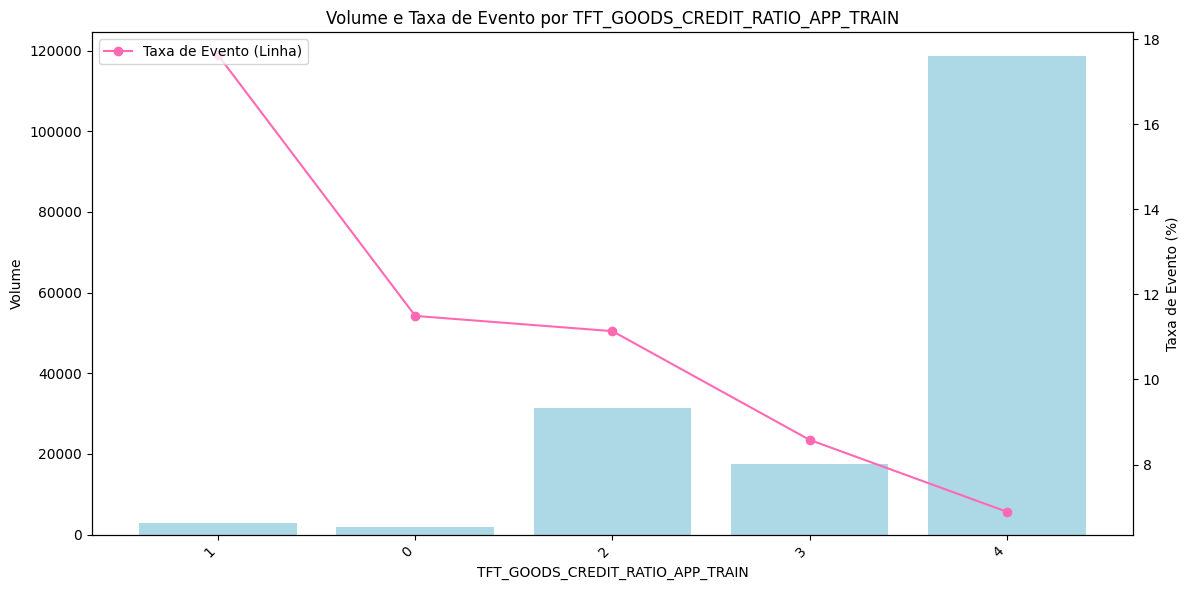

In [ ]:
# Plotando o resultado.
result = analyze_variable(abt_train_28, 'TFT_GOODS_CREDIT_RATIO_APP_TRAIN', 'TARGET')

In [ ]:
# Mostrando o resultado em um DataFrame.
result

,TFT_GOODS_CREDIT_RATIO_APP_TRAIN,Taxa_de_Evento,Volume
1,1,0.176232,2962
0,0,0.114936,1801
2,2,0.111353,31297
3,3,0.085801,17564
4,4,0.068906,118581


**Agrupando a variável TFT_GOODS_CREDIT_RATIO_APP_TRAIN**

In [ ]:
# Gerando o dicionário de domínios.
unique_values = abt_train_28['TFT_GOODS_CREDIT_RATIO_APP_TRAIN'].unique()

domain_map = {value: value for value in unique_values}

print('domain_map = {')
for key, value in domain_map.items():
    print(f"               '{key}': '{value}',")
print('              }')

domain_map = {
               '4': '4',
               '0': '0',
               '2': '2',
               '3': '3',
               '1': '1',
              }


In [ ]:
# Ajustando manualmente os agrupamentos de domínios.

domain_map = {
               '4': '4',
               '0': '0',
               '2': '0',
               '3': '3',
               '1': '1',
              }

In [ ]:
# Aplicando a transformação e gerando dataframe 'transformation' com as mudanças de domínios.
transformation = group_and_plot_by_safra(abt_train_28, 'TARGET', 'TFT_GOODS_CREDIT_RATIO_APP_TRAIN', domain_map)


# Aplicando as transformações e (criando novas tabelas).

# Aplica nos dados de treino.
abt_train_29 = apply_grouping(abt_train_28, transformation, 'TFT_GOODS_CREDIT_RATIO_APP_TRAIN')

# Aplica nos dados de teste.
abt_test_29 = apply_grouping(abt_test_28, transformation, 'TFT_GOODS_CREDIT_RATIO_APP_TRAIN')

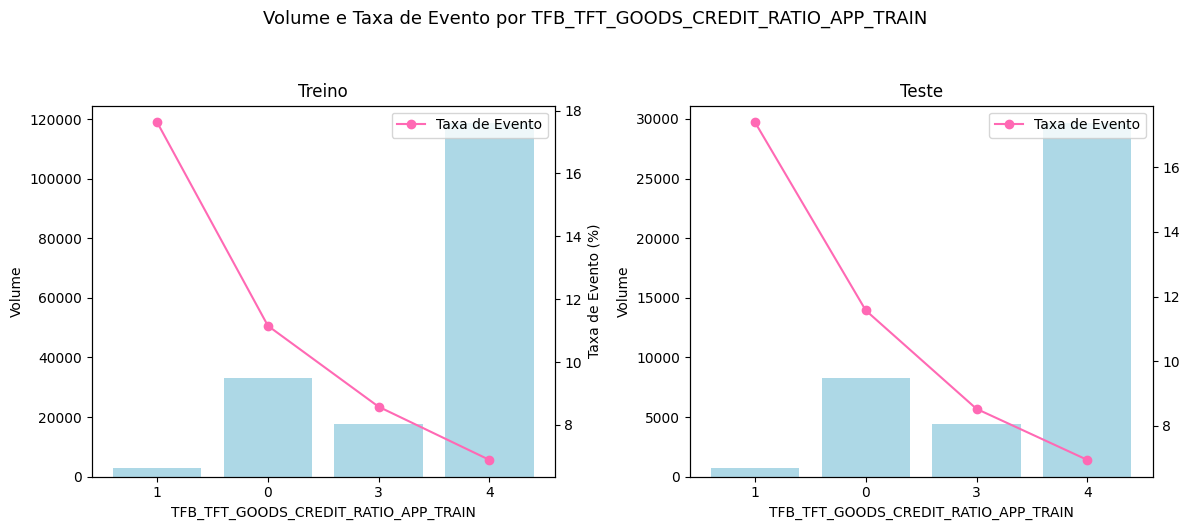

In [ ]:
# Visualizando a ordenação nos dados de treino e teste (usar prefixo TFB_ no nome da variável).
result = analyze_variable_train_and_test(abt_train_29, abt_test_29, 'TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN', 'TARGET')

<br>
<br>
<br>
<br>

## **Criação das variáveis Dummies**

In [ ]:
# Mostrando a tabela de treino.
abt_train_29.head()

,TARGET,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE,TFB_TFT_OCCUPATION_TYPE,TFT_DAYS_BIRTH,TFB_TFT_AMT_ANNUITY,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN
0,0,Cash loans,"Stone, brick",281575,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3,3,1,1,1,4
1,0,Cash loans,Panel,253241,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3,2,3,0,3,0
2,0,Cash loans,Panel,257591,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2,2,1,2,1,4
3,0,Cash loans,VERIFICAR,440634,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3,0,1,0,3,4
4,0,Cash loans,"Stone, brick",101232,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3,2,4,2,2,4


In [ ]:
# Mostrando a tabela de teste.
abt_test_29.head()

,TARGET,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE,SK_ID_CURR,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE,TFB_TFT_OCCUPATION_TYPE,TFT_DAYS_BIRTH,TFB_TFT_AMT_ANNUITY,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN
0,0,Revolving loans,VERIFICAR,243431,Working,Rented apartment,Incomplete higher,Unaccompanied,Civil marriage,4,4,2,2,3,4,2,3,3,3,4
1,0,Cash loans,Wooden,127962,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,3,4,4,2,3,3,2,3,0,2,4
2,1,Cash loans,Wooden,244667,Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,3,3,2,4,3,2,1,4
3,0,Cash loans,VERIFICAR,220032,Working,Rented apartment,Incomplete higher,Unaccompanied,Married,2,4,3,0,3,4,2,3,3,1,4
4,0,Cash loans,VERIFICAR,123746,Working,Municipal apartment,Higher education,"Spouse, partner",Married,3,4,4,0,3,3,0,1,1,1,3


In [ ]:
# Dropando colunas de Target e ID.
X = abt_train_29.drop(columns=['TARGET', 'SK_ID_CURR'])
X.head()

,NAME_CONTRACT_TYPE,WALLSMATERIAL_MODE,TFB_NAME_INCOME_TYPE,TFB_NAME_HOUSING_TYPE,TFB_NAME_EDUCATION_TYPE,TFB_NAME_TYPE_SUITE,TFB_NAME_FAMILY_STATUS,TFT_EXT_SOURCE_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,TFT_EXT_SOURCE_1,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,TFT_EXT_SOURCE_3,TFT_ORGANIZATION_TYPE,TFB_TFT_OCCUPATION_TYPE,TFT_DAYS_BIRTH,TFB_TFT_AMT_ANNUITY,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN
0,Cash loans,"Stone, brick",Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,3,4,4,2,3,3,3,1,1,1,4
1,Cash loans,Panel,Working,Municipal apartment,Incomplete higher,"Spouse, partner",Married,4,0,3,2,3,3,2,3,0,3,0
2,Cash loans,Panel,Working,Municipal apartment,Incomplete higher,Unaccompanied,Separated,4,4,3,4,3,2,2,1,2,1,4
3,Cash loans,VERIFICAR,Working,Municipal apartment,Incomplete higher,Unaccompanied,Married,2,0,3,2,3,3,0,1,0,3,4
4,Cash loans,"Stone, brick",Working,Municipal apartment,Incomplete higher,Unaccompanied,Civil marriage,2,4,3,0,3,3,2,4,2,2,4


In [ ]:
# Criando uma lista de variáveis a serem dumificadas.
lista_onehot = list(X.columns)

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de vars para OneHot Encoding: ', lista_onehot)
print('')
print('=' * 150 + Style.RESET_ALL)

# Instanciando o encoder.
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Aplicando o onehot encoding.
encoded_data = encoder.fit_transform(abt_train_29[lista_onehot])
encoded_cols = encoder.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=abt_train_29.index)

# Concatenando o resultado.
abt_train_30 = pd.concat([abt_train_29.drop(lista_onehot, axis=1), encoded_df], axis=1)

# Salva o encoder e a lista de colunas em um arquivo .pkl.
data_to_serialize = {
    'encoder': encoder,
    'columns': lista_onehot
}

with open(dir_pkl + '/prd_onehotenc_2.pkl', 'wb') as f:
    pickle.dump(data_to_serialize, f)


Lista de vars para OneHot Encoding:  ['NAME_CONTRACT_TYPE', 'WALLSMATERIAL_MODE', 'TFB_NAME_INCOME_TYPE', 'TFB_NAME_HOUSING_TYPE', 'TFB_NAME_EDUCATION_TYPE', 'TFB_NAME_TYPE_SUITE', 'TFB_NAME_FAMILY_STATUS', 'TFT_EXT_SOURCE_2', 'TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP', 'TFT_EXT_SOURCE_1', 'TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN', 'TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP', 'TFT_EXT_SOURCE_3', 'TFT_ORGANIZATION_TYPE', 'TFB_TFT_OCCUPATION_TYPE', 'TFT_DAYS_BIRTH', 'TFB_TFT_AMT_ANNUITY', 'TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN']



In [ ]:
abt_train_30.shape

(172205, 62)

In [ ]:
abt_train_30.head()

,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Student,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Higher education,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,"TFB_NAME_TYPE_SUITE_Spouse, partner",TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_3,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_3,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4
0,0,281575,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,253241,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,257591,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,440634,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,101232,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Carregando o encoder e a lista de colunas.
with open(dir_pkl + '/prd_onehotenc_2.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoder = loaded_data['encoder']
loaded_columns = loaded_data['columns']

# Aplicando na base de teste.
encoded_data_test = loaded_encoder.transform(abt_test_29[loaded_columns])
encoded_cols_test = loaded_encoder.get_feature_names_out(loaded_columns)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_cols_test, index=abt_test_29.index)

abt_test_30 = pd.concat([abt_test_29.drop(loaded_columns, axis=1), encoded_df_test], axis=1)

abt_test_30.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(43052, 62)

In [ ]:
abt_test_30.head()

,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Student,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Higher education,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,"TFB_NAME_TYPE_SUITE_Spouse, partner",TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_3,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_3,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4
0,0,243431,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,127962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,244667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,220032,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,123746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<br>

### **Verificando a matriz de correlação das variáveis dummificadas**

In [ ]:
# Dropando as colunas de Target e ID.
abt_train_31 = abt_train_30.drop(columns=['TARGET', 'SK_ID_CURR'])

# Calculando a correlação de Pearson.
corr_matrix_dummy = abt_train_31.corr()
corr_matrix_dummy

,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Student,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Higher education,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,"TFB_NAME_TYPE_SUITE_Spouse, partner",TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_3,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_3,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4
NAME_CONTRACT_TYPE_Revolving loans,1.000000,0.002601,0.008363,0.002364,0.012458,0.014990,-0.026259,-0.002648,0.014689,0.005847,-0.015508,0.001282,0.026166,0.061081,-0.056092,-0.015846,0.001106,-0.015078,0.009531,0.028243,-0.022792,0.002948,-0.020996,-0.010191,-0.013416,0.007260,0.008388,0.006642,0.068352,0.001795,0.014431,-0.015552,0.008154,0.436305,-0.126761,-0.111432,-0.031520,0.014937,0.007766,0.024959,-0.001371,0.001923,0.008440,-0.009336,0.003972,0.027285,0.005909,0.004474,-0.007203,0.003599,-0.015287,0.006093,0.017806,0.124010,-0.087810,0.265032,-0.007109,-0.042940,-0.109258,0.216946
WALLSMATERIAL_MODE_Mixed,0.002601,1.000000,-0.006596,-0.006261,-0.045162,-0.044274,-0.087695,-0.011518,-0.000855,-0.000776,0.001192,0.001679,-0.010322,0.011439,-0.010729,-0.003464,-0.002019,-0.005003,0.005103,-0.001461,-0.001756,0.003509,-0.001353,-0.006486,-0.006826,0.004152,0.004457,-0.000415,0.001758,-0.003098,-0.001276,-0.006793,0.008875,-0.001602,-0.002541,0.000804,-0.001300,-0.000350,-0.000866,0.002577,-0.002552,0.001535,-0.000103,0.000450,0.000906,0.001876,-0.000330,0.001035,-0.004285,-0.001283,0.003783,-0.000718,-0.002925,-0.001933,0.006033,-0.003820,0.009138,-0.000414,-0.006562,0.009177
WALLSMATERIAL_MODE_Monolithic,0.008363,-0.006596,1.000000,-0.005572,-0.040192,-0.039401,-0.078044,-0.010250,-0.000761,-0.000691,0.001061,0.002067,-0.002619,0.040876,-0.038626,-0.006490,-0.001763,-0.007869,0.007792,0.002008,0.000697,0.002882,-0.004685,-0.008586,-0.020159,-0.009990,0.030055,-0.000369,0.000941,-0.006108,-0.006070,-0.010206,0.016955,0.000132,-0.003824,-0.000527,-0.003723,-0.004020,0.002819,0.002489,0.002247,0.002193,-0.002781,-0.000404,0.000217,0.006257,-0.008615,-0.001064,-0.019308,-0.004440,0.001927,0.003761,-0.000491,-0.002031,0.013121,-0.000995,0.019510,-0.004859,-0.005417,0.007730
WALLSMATERIAL_MODE_Others,0.002364,-0.006261,-0.005572,1.000000,-0.038150,-0.037399,-0.074079,-0.009730,-0.000723,-0.000656,0.001007,0.006414,-0.007888,0.005768,-0.005546,-0.000854,0.000876,0.001513,-0.001369,0.001403,-0.002377,-0.000494,0.000537,-0.003025,-0.002640,-0.010189,0.013716,-0.000351,0.000910,-0.002390,-0.005749,0.000955,0.00321

In [ ]:
# Definindo limiar de correlação.
limiar_corr = 0.70

# Criando uma máscara para correlações maior ou igual ao valor absoluto do limiar.
mask = np.triu(np.ones_like(corr_matrix_dummy, dtype=bool))
high_corr = corr_matrix_dummy.mask(mask).abs() >= limiar_corr

# Criando uma lista para armazenar as colunas a serem removidas.
vars_corr_to_drop = [column for column in high_corr.columns if any(high_corr[column])]

# Removendo as colunas da matriz de correlação.
abt_train_32 = abt_train_31.drop(abt_train_31[vars_corr_to_drop], axis=1)

# Imprimindo variáveis dropadas.
print(Fore.BLUE + '=' * 150)
print('')
print('Variáveis excluídas por alta correlação: ', vars_corr_to_drop)
print('')
print('Tamanho do DataFrame: ', abt_train_32.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Variáveis excluídas por alta correlação:  ['TFB_NAME_INCOME_TYPE_Student', 'TFB_NAME_EDUCATION_TYPE_Higher education', 'TFB_NAME_TYPE_SUITE_Spouse, partner', 'TFT_EXT_SOURCE_1_3', 'TFT_EXT_SOURCE_3_3']

Tamanho do DataFrame:  (172205, 55)



In [ ]:
# Salvando a lista de variáveis dropadas em um arquivo .pkl (artefato).
with open(dir_pkl + '/prd_drop_vars_corr.pkl', 'wb') as f:
    pickle.dump(vars_corr_to_drop, f)

In [ ]:
# Carregando o pkl com a lista de variáveis a serem removidas.
with open(dir_pkl + '/prd_drop_vars_corr.pkl', 'rb') as f:
    loaded_pkl_drop_vars_corr = pickle.load(f)

# Aplicando a remoção das variáveis na tabela de teste.
abt_test_32 = abt_test_30.drop(columns=loaded_pkl_drop_vars_corr, axis=1)

abt_test_32.shape

(43052, 57)

In [ ]:
# Trazendo as colunas de Target e ID novamente.
abt_train_33 = abt_train_32.merge(abt_train_30[['TARGET', 'SK_ID_CURR']], left_index=True, right_index=True, how='inner')

abt_train_33.shape

(172205, 57)

In [ ]:
abt_train_33.head()

,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4,TARGET,SK_ID_CURR
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,281575
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,253241
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,257591
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,440634
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,101232


In [ ]:
# Fazendo uma cópia da base de teste para ficar com a mesma numeração da base de treino.
abt_test_33 = abt_test_32.copy()
abt_test_33.head()

,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4
0,0,243431,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,127962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,244667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,220032,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,123746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<br>
<br>
<br>
<br>

## **Salvando as ABTs tratadas e prontas para modelagem**

In [ ]:
# Salvando o conjunto de treino.
abt_train_33.to_csv(dir_abt + '/abt_train_01.csv', index=False)

In [ ]:
# Salvando o conjunto de teste.
abt_test_33.to_csv(dir_abt + '/abt_test_01.csv', index=False)